In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "pandas<2.0.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.collections import PathCollection
import geopandas as gpd
import pandas as pd
import numpy as np
import gzip
import pickle
import copy
import kDNA_annotation as ka
#statistics
import statistics
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import binomtest
from scipy.stats import ttest_rel
plt.show()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d")

In [4]:
#get deletion and editing seuqences
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
#
def strain_minis(csv):
    df=pd.read_csv(csv,index_col='renamed') #set a new index
    mini_dict={strain:set(df.loc[strain][~(df.loc[strain].isna())].index) for strain in df.index}
    return(mini_dict)


def get_gRNA_info (txt,csv=False,matches=False):
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{index}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for index,line in enumerate(handle)}
        mRNA_dict={gRNA_dict[key]['mRNA_name']:[] for key in gRNA_dict}
        for key in gRNA_dict:
            x1=int(gRNA_dict[key]['mRNA_start'])
            x2=int(gRNA_dict[key]['mRNA_end'])
            x3=int(gRNA_dict[key].get('anchor_len',6))
            x4=gRNA_dict.get('expression','expressed')
            mRNA_dict[gRNA_dict[key]['mRNA_name']].append((x1,x2,x3,x4))
        if matches != False:
            #matches='/home/jovyan/minicircle_annotation/Tbg1_cleaned_minicircles.log'
            match_dict={list(filter(None,l.strip('\n').split(' ')))[1]:list(filter(None,l.strip('\n').split(' ')))[0] for l in open(matches)} #translate mini naming system
            print(match_dict)
            for k in gRNA_dict:
                gRNA_dict[k]['mO_name']=match_dict[gRNA_dict[k]['mO_name']]
    #assign minicircle/gRNAs to each strain (using old copy number analysis)
    return(gRNA_dict,mRNA_dict)

def find_gap2(dictionary,insertions,key): #mrna_dict
    gaps,edits=[],copy.deepcopy(insertions)
    for i in sorted(dictionary[key]):
        for site in range(i[0],i[1]-6):
            edits[site]+=1
    x=[i for i,j in enumerate(edits) if j ==0]
    return(x)

def draw_grna(coor,adj=0,y=0.5,color='blue'):
    xstart=int(coor[0])-adj
    xend=int(coor[1])-adj
    anchor_len=int(coor[2])
    hl=(xend-xstart)/10
    plt.arrow(xend,y,-anchor_len,0,head_width=0, head_length=0, width=0.2,fc='red', ec='None',alpha=0.5) #draw anchor
    plt.arrow(xend-anchor_len,y,(xstart-xend+anchor_len+hl),0,head_width=0.2, head_length=hl, width=0.2,fc=color, ec=color,alpha=0.5)
    #plt.vlines(xstart,1,y,colors='k',linestyles='dashed',alpha=0.4)

def plot_alignment(dictionary,key,y=1,adj=0,arrowcolor='skyblue',up=False,fold=3):
    yheight,count,y0=len(dictionary[key])/fold,0,y
    for coor in sorted(dictionary[key],key=lambda x:x[1]):
        draw_grna(coor,adj,y=y,color=arrowcolor)
        count+=1
        if up == False:
            y-=0.2
        else:
            y+=0.2
        if count >= yheight:
            ymin=y
            y=y0
            count=0
    return(ymin)
    
def gRNA_depth(mRNA,mrna_dict,key):
    total=np.array([0]*len(mRNA))
    for pair in mrna_dict[key]:
        total+=np.array([0]*(pair[0]-1)+[1]*(pair[1]-pair[0]-8+1)+[0]*(len(mRNA)-pair[1]+8)) #-8 instead -pair[2]
    return(total)

def plot_mRNA_gRNA(mRNAs,strain_mrna,key,Outdir,lw=4, #mRNA-dicts+strain--> strain_mrna
                   y=0.1,adj=0,arrowcolor='black',up=False,fold=3,figw=20,figh=10,output='mRNA_coverage'): #with dots
    #
    insertions=[0 if b=='u' else 1 for b in mRNAs[key]['seq']] #read_editing_sites(small_u)
    deletion=[0 if b!='-' else 1 for b in mRNAs[key]['deletions']] #read_deletion_sites(dels)
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))   
    axs.axis('off')
    start=-0.3
    ymin=0
    #label numbers for mRNA length
    for i in range(0,len(insertions),50):
        axs.text(i,ymin,f"{i}",fontsize=10)
    ymin-=0.5
    #draw insertion sites: 0 for insertions
    x=[i for i,c in enumerate(insertions) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='purple',linewidth=5)
    ymin-=1
    #draw deletions
    x=[i for i,c in enumerate(deletion) if c==0 ] 
    y=[ymin]*len(x)
    axs.scatter(x,y,marker=3,color='red',linewidth=5)
    ymin+=-1
    #find the last editing site
    last1,last2=0,0
    for i,b in enumerate(deletion):
        if b=='0':
            last1=i
    for i,b in enumerate(insertions):
        if b=='0':
            last2=i
    last=max(last1,last2)
    #plot gRNA alignment
    gaps,gap_dict=[],{}
    for strain in strain_mrna:
        ymin-=2
        mRNA_dict=strain_mrna[strain]
        yprevious=ymin
        y=ymin
        ymin=plot_alignment(mRNA_dict,key,y,adj,arrowcolor,up,fold)
        axs.hlines(ymin,0,len(insertions),colors='k',linestyles='dashed',alpha=0.4)
        axs.text(0,ymin,f"{strain} {key}",fontsize=25,horizontalalignment='right')
        y=ymin-0.5
        #plot gRNA coverage on mRNA
        #grna_depth=gRNA_depth(mRNA,mRNA_dict,key) 
        #axs.plot(range(len(mRNA)),grna_depth,label=f'gRNA coverage {strain}')
        x=find_gap2(mRNA_dict,insertions,key)
        if x !='[]':
            axs.plot(x,[yprevious+1]*len(x),'^',color='black')
            for i in x:
                axs.vlines(i,yprevious+1,ymin,colors='k',linestyles='dashed',alpha=0.4)
        #print(find_gap(mRNA_dict,key),ymin,yprevious)
    #plot borders of gRNA coverage gaps
    #gaps=find_gap(mRNA_dict,key)
    #if the last editing sites are covered:
    axs.tick_params(axis='y', labelsize= 15)
    #axs.set_facecolor("white")
    plt.savefig(f'{Outdir}/{output}.pdf', format="pdf", bbox_inches="tight")
    plt.show()
    return(insertions)
# LOAD FEATURE FILES
def set_prefix(prefix):
    fig_dir = f'{prefix}_Figures'
    tab_dir = f'{prefix}_Tables'
    config_file = f'config_{prefix}.yaml'
    return(fig_dir,tab_dir,config_file)

In [5]:
#coverage summary
def gRNA_coverage(mRNAs,strain,outdir,width=0.35, figw=30,figh=10):
    df = pd.DataFrame(columns=['all insertions','covered insertions','uncovered insertions','all deletions','covered deletions','uncovered deletions'], index=mRNAs.keys())
    for k in mRNAs:
        inserts=[0 if b=='t' else 1 for b in mRNAs[k]['edits']] #0 for editing sites
        dels=[0 if i=='-' else int(i) for i in mRNAs[k]['deletions']] #record the actual number of deleted U
        edited=mRNAs[k]['edited']
        inserted=[0 if i==0 and j ==0 else 1 for i,j in zip(inserts,edited)] #0 for uncovered editing sites, 1 for other
        deleted=[i if j==0 else 0 for i,j in zip(dels, edited)]
        #populate df
        if k in ['MURF2','COX2']:
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)
            df.loc[k,'uncovered insertions']=0
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)
            df.loc[k,'uncovered deletions']=0
        else:
            df.loc[k,'all insertions']=inserts.count(0)
            df.loc[k,'covered insertions']=inserts.count(0)-inserted.count(0)
            df.loc[k,'uncovered insertions']=inserted.count(0)
            df.loc[k,'all deletions']=sum(dels)
            df.loc[k,'covered deletions']=sum(dels)-sum(deleted)
            df.loc[k,'uncovered deletions']=sum(deleted)
  #output df for a quick check
    print(df)
    df.to_csv(f'{outdir}/{strain}_gRNA_coverage.csv', index=True)  
  #plot the statistics
    fig,axs = plt.subplots(1,1,figsize=(figw,figh))  
    x=np.arange(0,len(df.index),1)*(width*1.2)
    axs.bar(x, (df['covered insertions']+df['covered deletions']), width, label='covered',
              color='cornflowerblue')
    axs.bar(x, (df['uncovered insertions']+df['uncovered deletions']), width, 
              bottom=(df['covered insertions']+df['covered deletions']),label='not covered',
              color='lightcoral')
  #styling
    axs.set_xticks(x)
    axs.set_xticklabels(list(df.index),) # have to do this seperate from set_xticks, otherwise error
    axs.tick_params(axis='x', labelsize= 20)
    axs.tick_params(axis='y', labelsize= 15)
    axs.set_xlabel('mRNAs',fontsize=20)
    axs.set_ylabel('Number of Editing sites',fontsize=20)
  #axs.set_title(title,fontsize=20) 
    axs.set_facecolor("white")
  #legend
    handles1, labels1 = axs.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=axs.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
  #plt.grid(True)
    plt.show()
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[1 if b=='u' else 0 for b in smallu[k].seq] #1 for insertions
        edits[k]=sites
    return(edits)

In [19]:
def freq_editing_site_coverage(strain_gRNA,small_u,anchor=6):
    #v1_unique=['ND8_v1-402_407','ND8_v1-542_546','A6_v1-799_801']
    #to_plot=[['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB'],['ND3','ND7', 'ND8_v1', 'ND8_v2', 'ND9', 'RPS12']]
    es={}
    for s in strain_gRNA:
        insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
        insertions={k:[0 if i=='u' else 0 for i in v] for k,v in insertions.items()} #all 0, U insertions are not treated differently
        #insertions={k:[0 if i==1 else 0 for i in v] for k,v in insertions.items()} #insertions are 0
        for g,v in strain_gRNA[s].items():
            coverage=(int(v['mRNA_start']),int(v['mRNA_end'])-anchor)
            mrna=v['mRNA_name']
            for i in range(coverage[0],min(coverage[1],len(insertions[mrna]))):
                insertions[mrna][i]+=1 #+1 if the base is covered by gRNA
            #take care of the shared gRNAs for alternatively editing mRNAs
        es[s]=insertions #use only the strain name, not the renamed version
    dfs={mrna:pd.DataFrame.from_dict({s:es[s][mrna] for s in es},orient='index') for mrna in insertions}
    return(dfs)
#
def plot_coverage_depth(dfs,insertions,figsize=(30, 20)): #method 1: each data point is an uridine insertion
    fig, axs = plt.subplots(nrows=6, ncols=2, figsize=figsize, sharey=False)
    to_plot=[['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB'],['ND3_v1','ND3_v2','ND7', 'ND8', 'ND9', 'RPS12']]
    for i in range(2):
        for j in range(6):
            ax=axs[j,i]
            mrna,data=to_plot[i][j],{}
            print(mrna)
            for s in dfs[mrna].index:
                tmp=dfs[mrna].loc[s]
                #average depth at each u insertion, averaged over isolates of asubspecies
                avg_depth=[i for i,j in zip(tmp,insertions[mrna]) if j==1] 
                data[s]=avg_depth
            boxprops = dict(linestyle='-', linewidth=4, color='b')
            medianprops = dict(linestyle='-', linewidth=4, color='r')
            ax.boxplot(data.values(),labels=data.keys(),vert=False,boxprops=boxprops,medianprops=medianprops)
            ax.tick_params(labelsize=20)
            ax.set_yticklabels(data.keys()) #,style='italic')
            ax.set_xlabel(f'{mrna} unique gRNA count/insertion',fontsize=20)
            ax.set_xlim(left=-1)
            pairs=combinations(data.keys(), 2)
            for p in pairs:
                query=data[p[0]]
                subject=data[p[1]]
                a=ttest_ind(subject, query)
                if a.pvalue<0.05:
                    meanq=sum(data[p[0]])/len(data[p[0]])
                    means=sum(data[p[1]])/len(data[p[1]])
                    print(f"{p[0]} {meanq} vs {p[1]} {means} {a.pvalue}")        
    plt.show()

##
#line plot with error bar full length
def plot_coverage_depth_line_nucleotied_freq(dfs,insertions,small_u,w=30,figsize=(30, 20)): 
    to_plot=['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB','ND3_v1','ND3_v2','ND7', 'ND8', 'ND9', 'RPS12']
    fig, axs = plt.subplots(nrows=len(to_plot), ncols=1, figsize=figsize, sharey=False)
    colors={'IL3000':'lightcoral','Kapeya':'limegreen','UPKZN':'slateblue'}
    mrnas=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    for i,mrna in enumerate(to_plot):
        ax=axs[i]
        for s in dfs[mrna].index:
            ax.plot(range(len(dfs[mrna].loc[s])),dfs[mrna].loc[s],label=s,alpha=0.5,color=colors[s],linewidth=8)
        ax.set_xlabel(f'{mrna} (nt)',fontsize=25)
        ax.set_ylabel(f'unique gRNA counts (nt)',fontsize=25)
        #plot U frequency
        mseq=mrnas[mrna].seq.upper()
        ufreq=[mseq[i-w:i+w].count('U')/w for i in range(w,len(mseq)-w,1)]
        ax.tick_params(labelsize=20)
        ax.legend(prop={'size': 20})
        #ax2 = ax.twinx()
        #ax2.plot(np.arange(w,len(mseq)-w,1),ufreq,color='k')
        #ax2.hlines(0.2,0,len(ufreq))
        #plot mRNA nucleotides
        #colorlgd={'A':'g','U':'r','C':'b','G':'orange'}
        #ax2.scatter(range(len(mseq)),[0]*len(mseq),c=[colorlgd.get(b,'white') for b in mseq],marker='|')
       # for i,b in enumerate(mseq):
       #     ax2.plot([i,i],[-1,0],color=colorlgd[b],linewidth=4,label=b)
    plt.show()

#make plot for gRNA copy number
def make_match_dict(clean_mini_log):
    match_dict={list(filter(None,l.strip('\n').split(' ')))[0]:list(filter(None,l.strip('\n').split(' ')))[1] for l in open(clean_mini_log)}
    match_dict['Maxicircle']='Maxicircle'
    return(match_dict)
def add_gRNA_copy(gRNA_dict,match_dict,strain,cpdf):
    for k,v in gRNA_dict.items():
        minimatch=match_dict[v['mO_name']]
        #print(minimatch)
        v['copy']=cpdf.loc[strain][minimatch]
def freq_editing_site_copy(strain_gRNA,small_u,anchor=6):
    es={}
    for s in strain_gRNA:
        insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
        insertions={k:[0 if i=='u' else 0 for i in v] for k,v in insertions.items()} #all 0, U insertions are not treated differently
        for g,v in strain_gRNA[s].items():
            coverage=(int(v['mRNA_start']),int(v['mRNA_end'])-anchor)
            mrna=v['mRNA_name']
            for i in range(coverage[0],min(coverage[1],len(insertions[mrna]))):
                insertions[mrna][i]+=v['copy'] #+1 if the base is covered by gRNA
            #take care of the shared gRNAs for alternatively editing mRNAs
        es[s]=insertions #use only the strain name, not the renamed version
    dfs={mrna:pd.DataFrame.from_dict({s:es[s][mrna] for s in es},orient='index') for mrna in insertions}
    return(dfs)

file config_Kapeya.yaml loaded
file /home/jovyan/gRNA_analysis/Work_files_Kapeya/features.pickle.gz loaded
       all insertions covered insertions uncovered insertions all deletions  \
A6_v1             458                458                    0            30   
A6_v2             459                459                    0            30   
COX2                4                  4                    0             0   
COX3              559                544                   15            35   
CR3               146                136                   10             7   
CR4               315                300                   15            32   
CYB                36                 36                    0             0   
MURF2              25                 25                    0             1   
ND3_v1            196                196                    0            28   
ND3_v2            197                192                    5            26   
ND7               558   

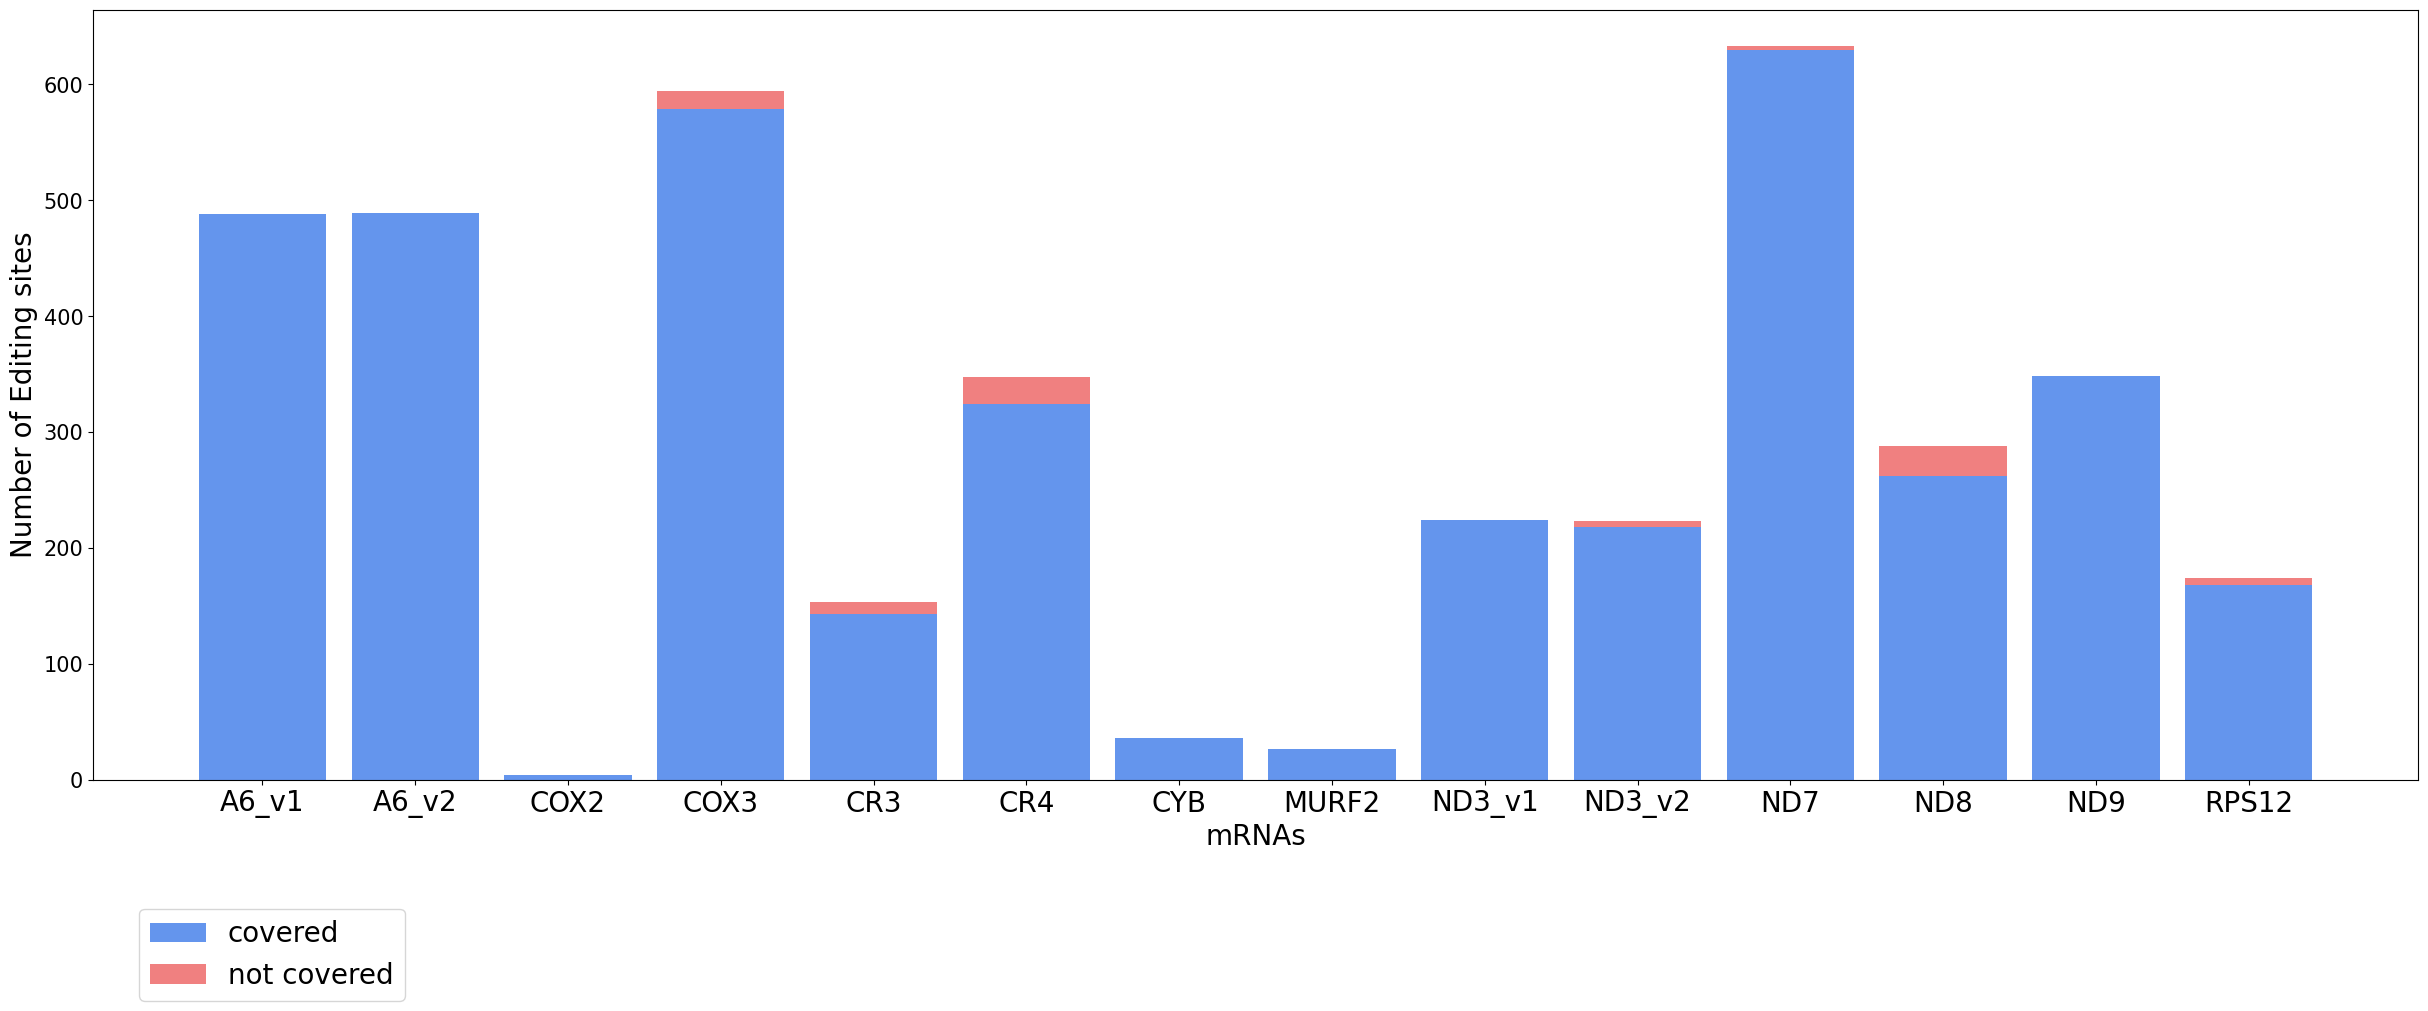

In [7]:
figure_dir,tables_dir,config_file=set_prefix('Kapeya')
config = ka.load_config(config_file)
work_dir, annotation_dir = ka.get_directories(config)[1:3]
gRNA_exp='/home/jovyan/Tcongo_PacBio/Infiles/Kepeya_gRNAs_2024-09-13.txt'
outdir='/home/jovyan/Tcongo_PacBio/Kapeya'
#
grna_k,mrna_k=get_gRNA_info (gRNA_exp)
features = f"{work_dir}/{config['features pickle file']}"
minicircles, mRNAs, CSB1, CSB2, CSB3, cassettes, gRNAs_all = ka.gzip_pickle_load(features)
gRNA_coverage(mRNAs,'Kapeya', outdir,width=0.35, figw=30,figh=10)

file config_UPKZN.yaml loaded
file /home/jovyan/gRNA_analysis/Work_files_UPKZN/features.pickle.gz loaded
       all insertions covered insertions uncovered insertions all deletions  \
A6_v1             458                448                   10            30   
A6_v2             459                448                   11            30   
COX2                4                  4                    0             0   
COX3              559                546                   13            35   
CR3               146                139                    7             7   
CR4               315                294                   21            32   
CYB                36                 30                    6             0   
MURF2              25                 25                    0             1   
ND3_v1            196                196                    0            29   
ND3_v2            197                197                    0            27   
ND7               558     

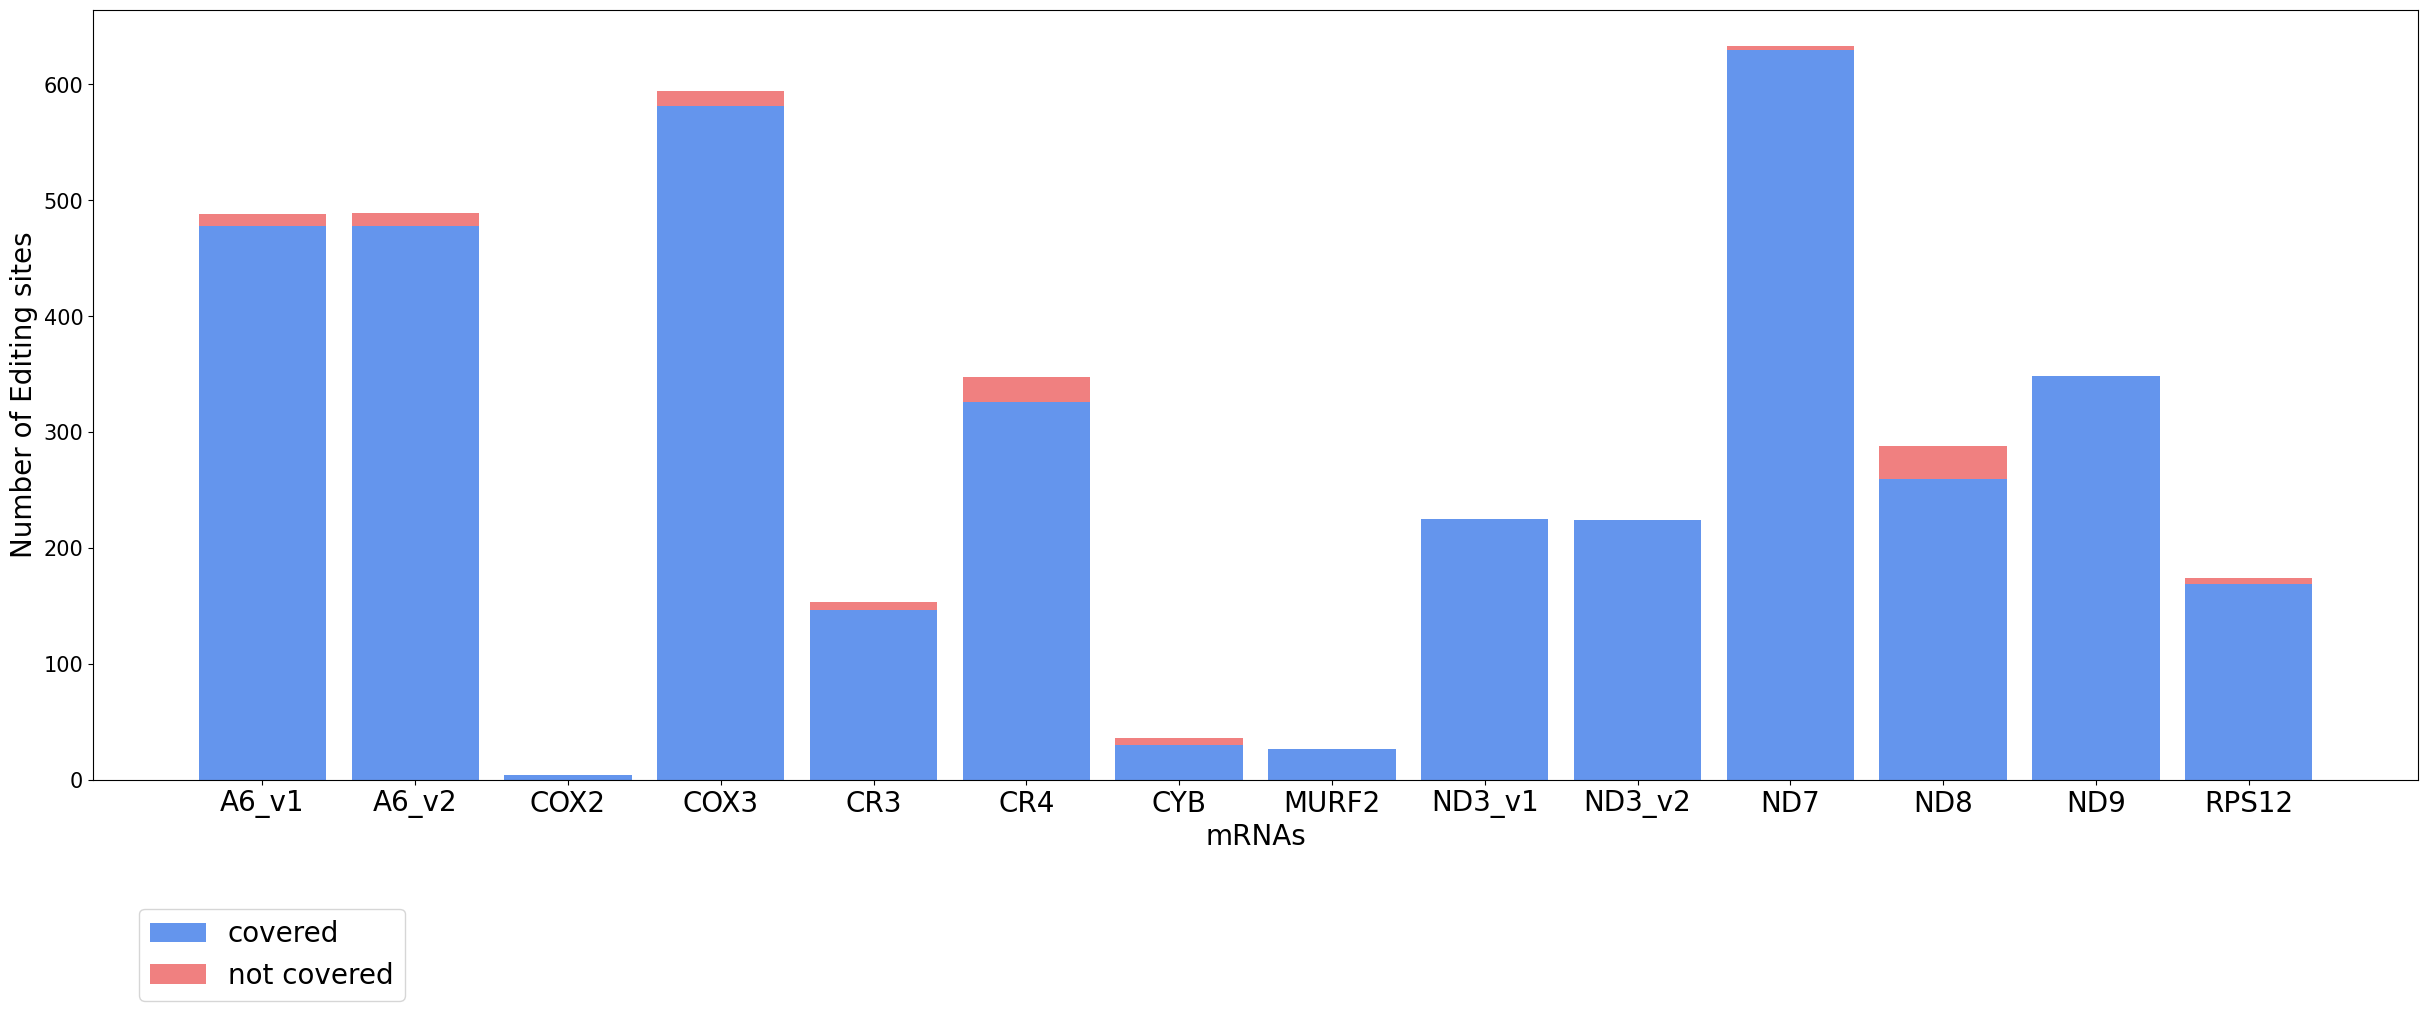

In [8]:
figure_dir,tables_dir,config_file=set_prefix('UPKZN')
config = ka.load_config(config_file)
work_dir, annotation_dir = ka.get_directories(config)[1:3]
#
gRNA_exp='/home/jovyan/Tcongo_PacBio/Infiles/UPKZN_gRNAs_2024-06-05.txt'
outdir='/home/jovyan/Tcongo_PacBio/UPKZN'
grna_up,mrna_up=get_gRNA_info (gRNA_exp)
features = f"{work_dir}/{config['features pickle file']}"
minicircles, mRNAs, CSB1, CSB2, CSB3, cassettes, gRNAs_all = ka.gzip_pickle_load(features)
gRNA_coverage(mRNAs,'Kapeya', outdir,width=0.35, figw=30,figh=10)

file config_IL3000.yaml loaded
file /home/jovyan/gRNA_analysis/Work_files_IL3000/features.pickle.gz loaded
       all insertions covered insertions uncovered insertions all deletions  \
A6_v1             458                450                    8            30   
A6_v2             459                451                    8            30   
COX2                4                  4                    0             0   
COX3              559                559                    0            35   
CR3               146                146                    0             7   
CR4               315                311                    4            32   
CYB                36                 36                    0             0   
MURF2              25                 25                    0             1   
ND3_v1            196                196                    0            29   
ND3_v2            197                197                    0            27   
ND7               558   

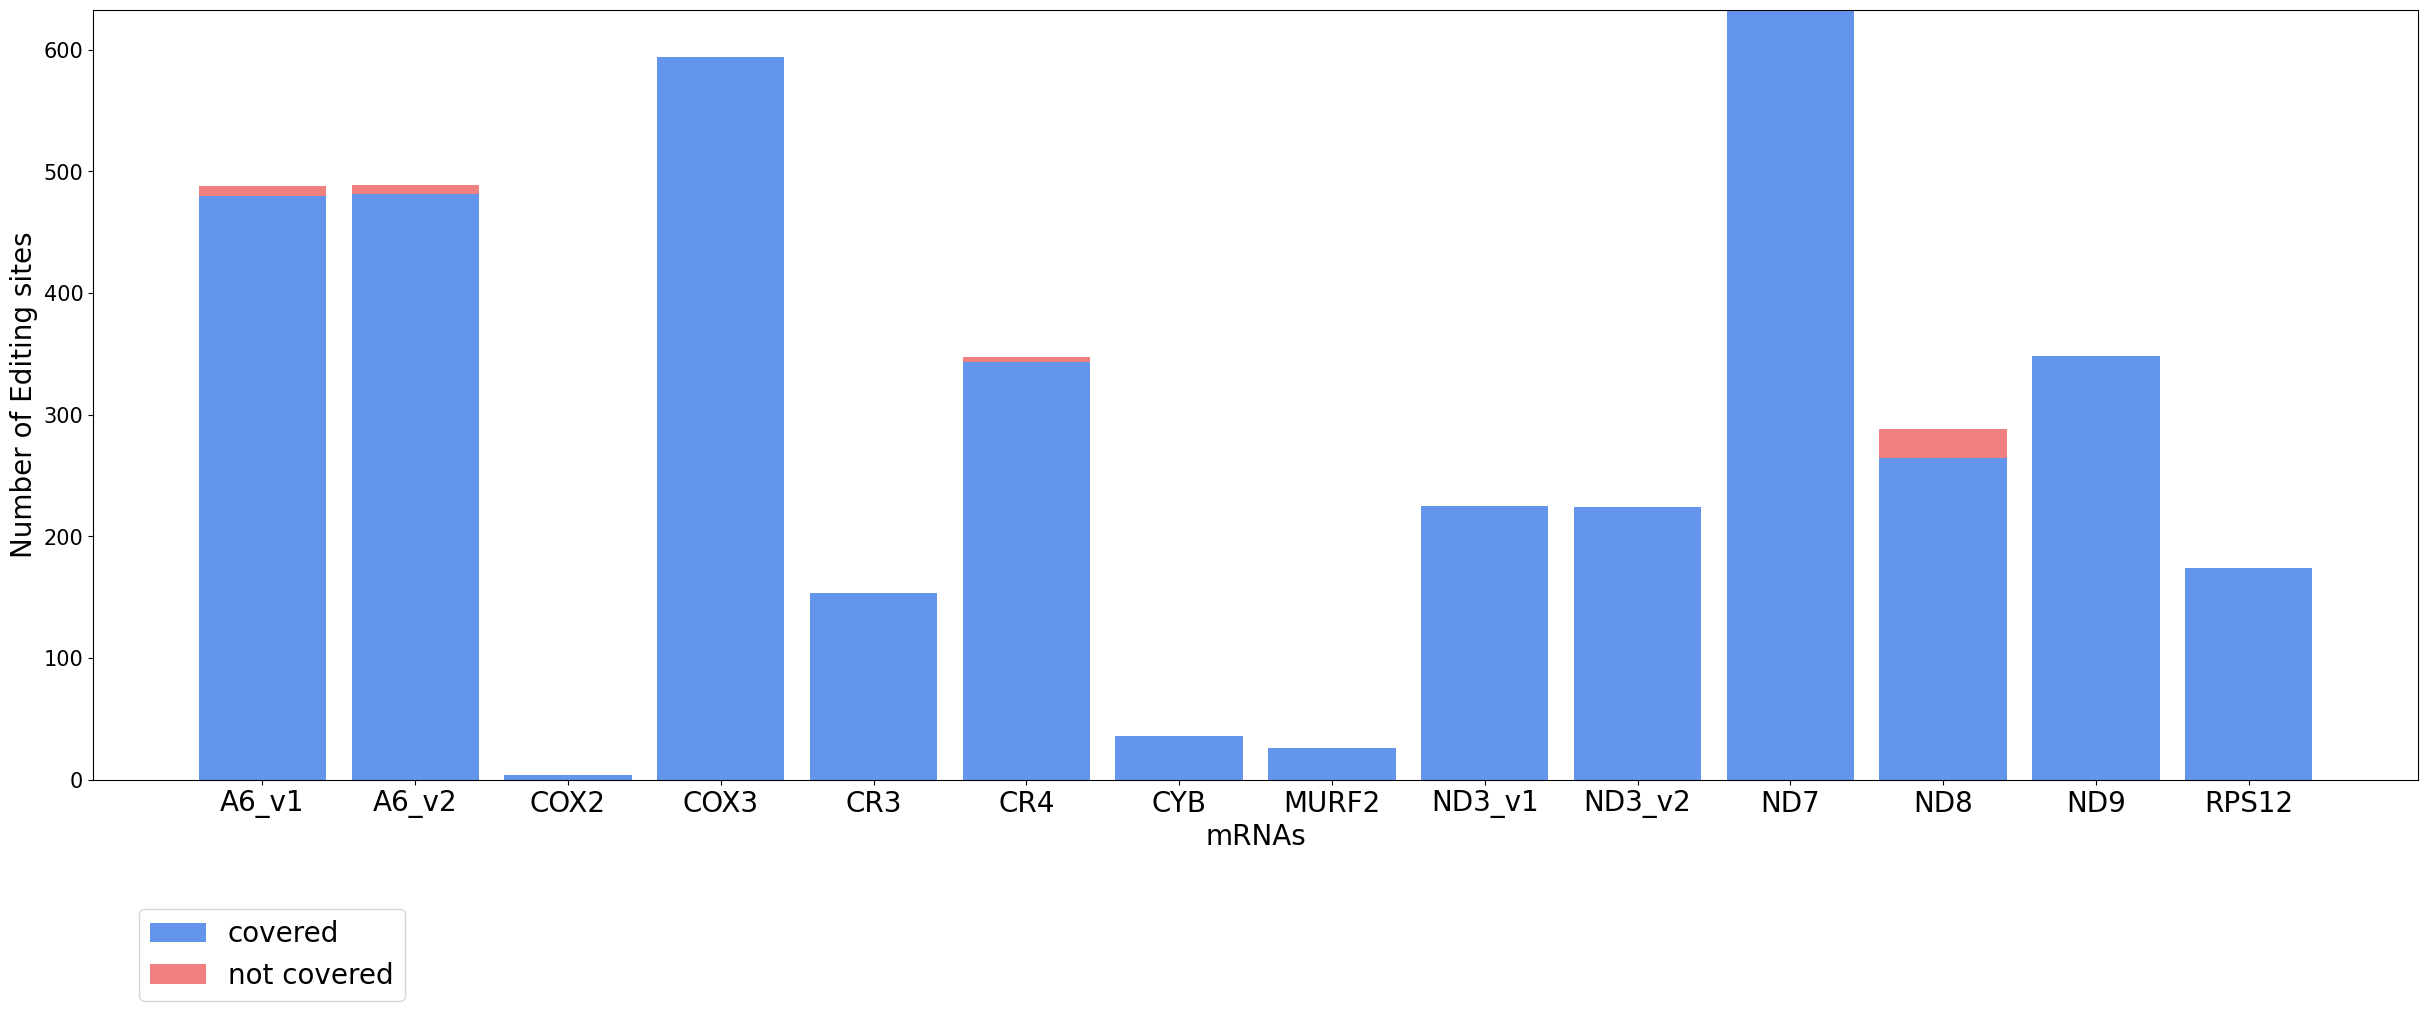

In [9]:
#mRNA
#gRNA_exp='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_gRNAs_with_expression.txt_2024-05-08.txt'
gRNA_exp='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_gRNAs_2024-09-13.txt'
outdir='/home/jovyan/Tcongo_PacBio/IL3000'
figure_dir,tables_dir,config_file=set_prefix('IL3000')
config = ka.load_config(config_file)
work_dir, annotation_dir = ka.get_directories(config)[1:3]
#
grna_il,mrna_il=get_gRNA_info (gRNA_exp)
features_file = f"{work_dir}/{config['features pickle file']}"
minicircles, mRNAs, CSB1, CSB2, CSB3, cassettes, gRNAs_all = ka.gzip_pickle_load(features_file)
gRNA_coverage(mRNAs,'IL3000', outdir,width=0.35, figw=30,figh=10)

In [10]:
ilmatch='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_cleaned_minicircles.log'
kmatch='/home/jovyan/Tcongo_PacBio/Infiles/Kapeya_cleaned_minicircles.log'
upmatch='/home/jovyan/Tcongo_PacBio/Infiles/UPKZN_cleaned_minicircles.log'
copycsv='/home/jovyan/Tcongo_PacBio/Infiles/copy.20240430.csv'
depthcsv='/home/jovyan/Tcongo_PacBio/Infiles/depth.20240430.csv'
#read csv
cpdf=pd.read_csv(copycsv,index_col=0)
cpdf['Maxicircle']=30
depth=pd.read_csv(depthcsv,index_col=0)
ilmatch_dict=make_match_dict(ilmatch)
kmatch_dict=make_match_dict(kmatch)
upmatch_dict=make_match_dict(upmatch)
#add copy number info
add_gRNA_copy(grna_il,ilmatch_dict,'IL3000',cpdf)
add_gRNA_copy(grna_k,kmatch_dict,'Kapeya',cpdf)
add_gRNA_copy(grna_up,upmatch_dict,'UPKZN',cpdf)

In [11]:
small_u='/home/jovyan/Tcongo_PacBio/Infiles/edited_mRNA_small_u.fasta'
insertions=read_editing_sites(small_u)
strain_gRNA={'IL3000':grna_il,'Kapeya':grna_k,'UPKZN':grna_up}
#rename gRNAs
def add_prefix(strain_gRNA):
    for s,grnas in strain_gRNA.items():
        for k,v in grnas.items():
            v['mO_name']=f"{s}_{v['mO_name']}"
        strain_gRNA[s]={f"{s}_{k}":v for k,v in grnas.items()}

add_prefix(strain_gRNA)#only need to run once
dfs=freq_editing_site_coverage(strain_gRNA,small_u,anchor=6)

A6_v1
IL3000 2.9716157205240177 vs Kapeya 3.8995633187772927 1.1194777403604187e-15
IL3000 2.9716157205240177 vs UPKZN 5.259825327510917 8.549289067820396e-52
Kapeya 3.8995633187772927 vs UPKZN 5.259825327510917 1.7161068662068357e-22
A6_v2
IL3000 2.895424836601307 vs Kapeya 3.710239651416122 1.4160577310500178e-12
IL3000 2.895424836601307 vs UPKZN 5.098039215686274 7.604103863937425e-49
Kapeya 3.710239651416122 vs UPKZN 5.098039215686274 1.7558987558401625e-23
COX3
IL3000 3.8318425760286225 vs Kapeya 6.1180679785330945 7.910595647773352e-48
IL3000 3.8318425760286225 vs UPKZN 9.17531305903399 1.3505514257427024e-122
Kapeya 6.1180679785330945 vs UPKZN 9.17531305903399 9.85764610513936e-40
CR3
IL3000 3.6780821917808217 vs Kapeya 2.308219178082192 1.2279197395946384e-09
IL3000 3.6780821917808217 vs UPKZN 4.863013698630137 1.9026357223882814e-06
Kapeya 2.308219178082192 vs UPKZN 4.863013698630137 9.410310834189253e-22
CR4
IL3000 2.511111111111111 vs Kapeya 3.1365079365079365 6.557014224537

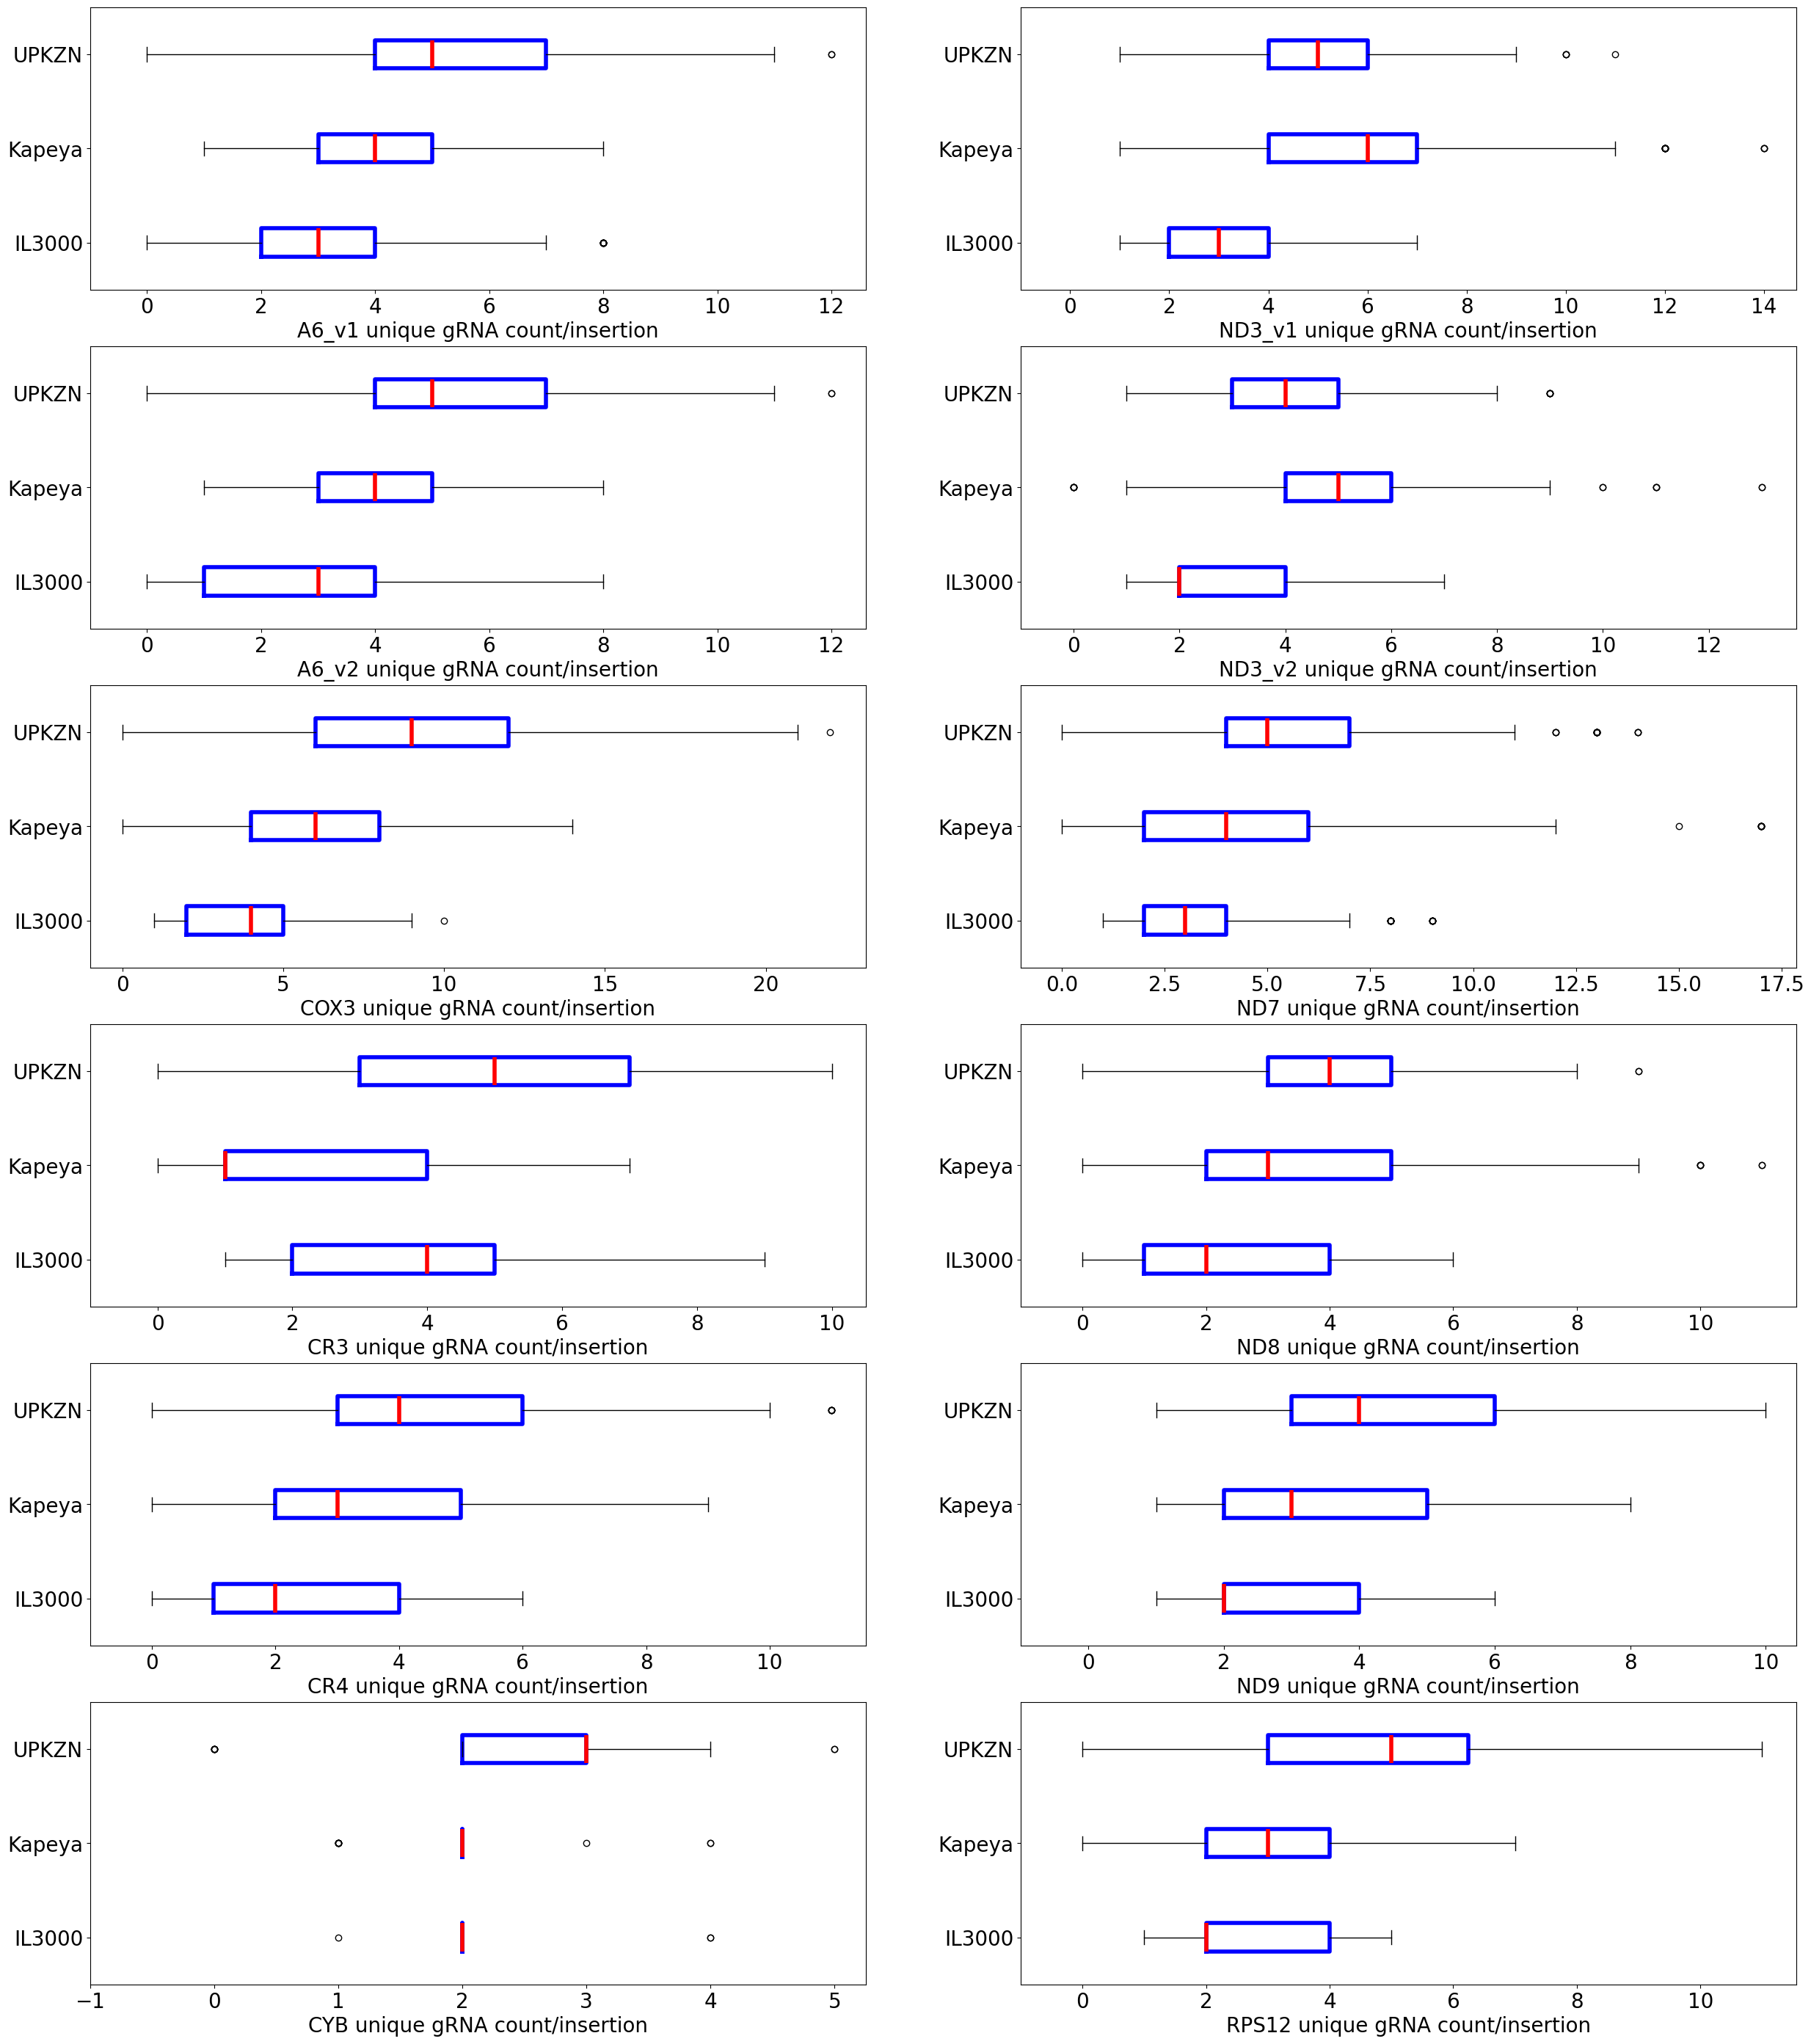

In [20]:
plot_coverage_depth(dfs,insertions,figsize=(30, 35))

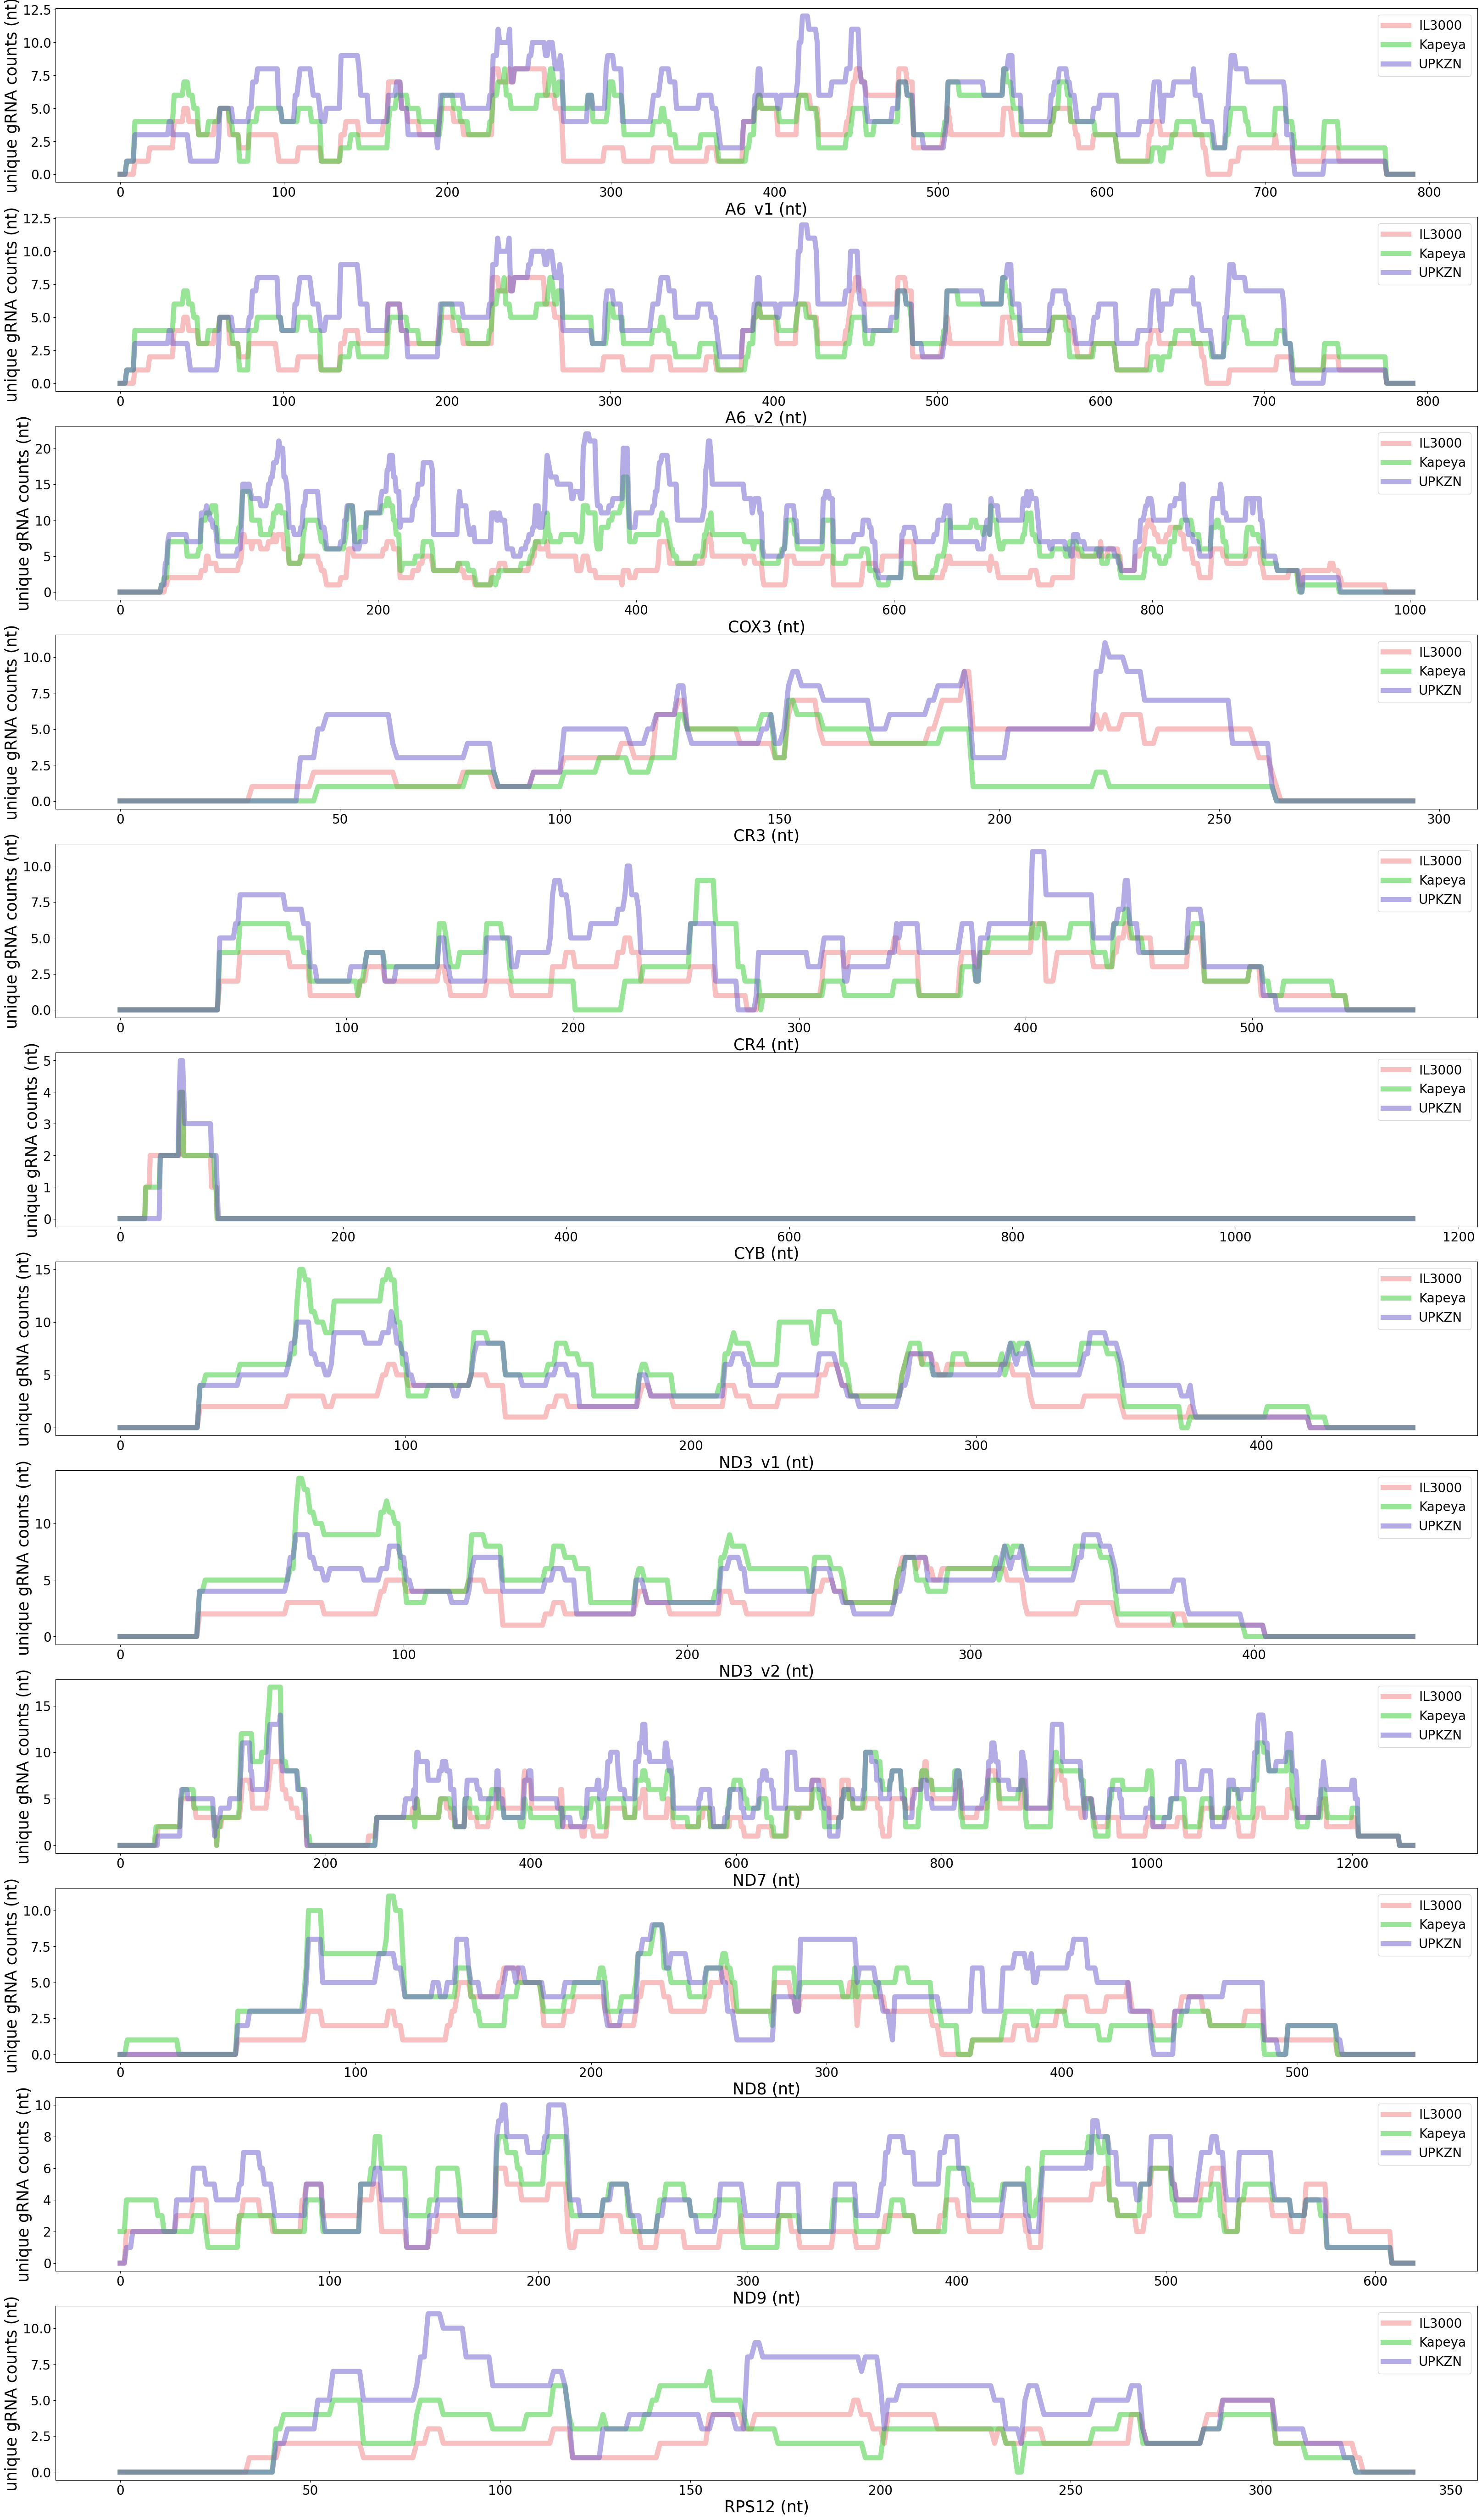

In [18]:
plot_coverage_depth_line_nucleotied_freq(dfs,insertions,small_u,w=30,figsize=(40, 70))

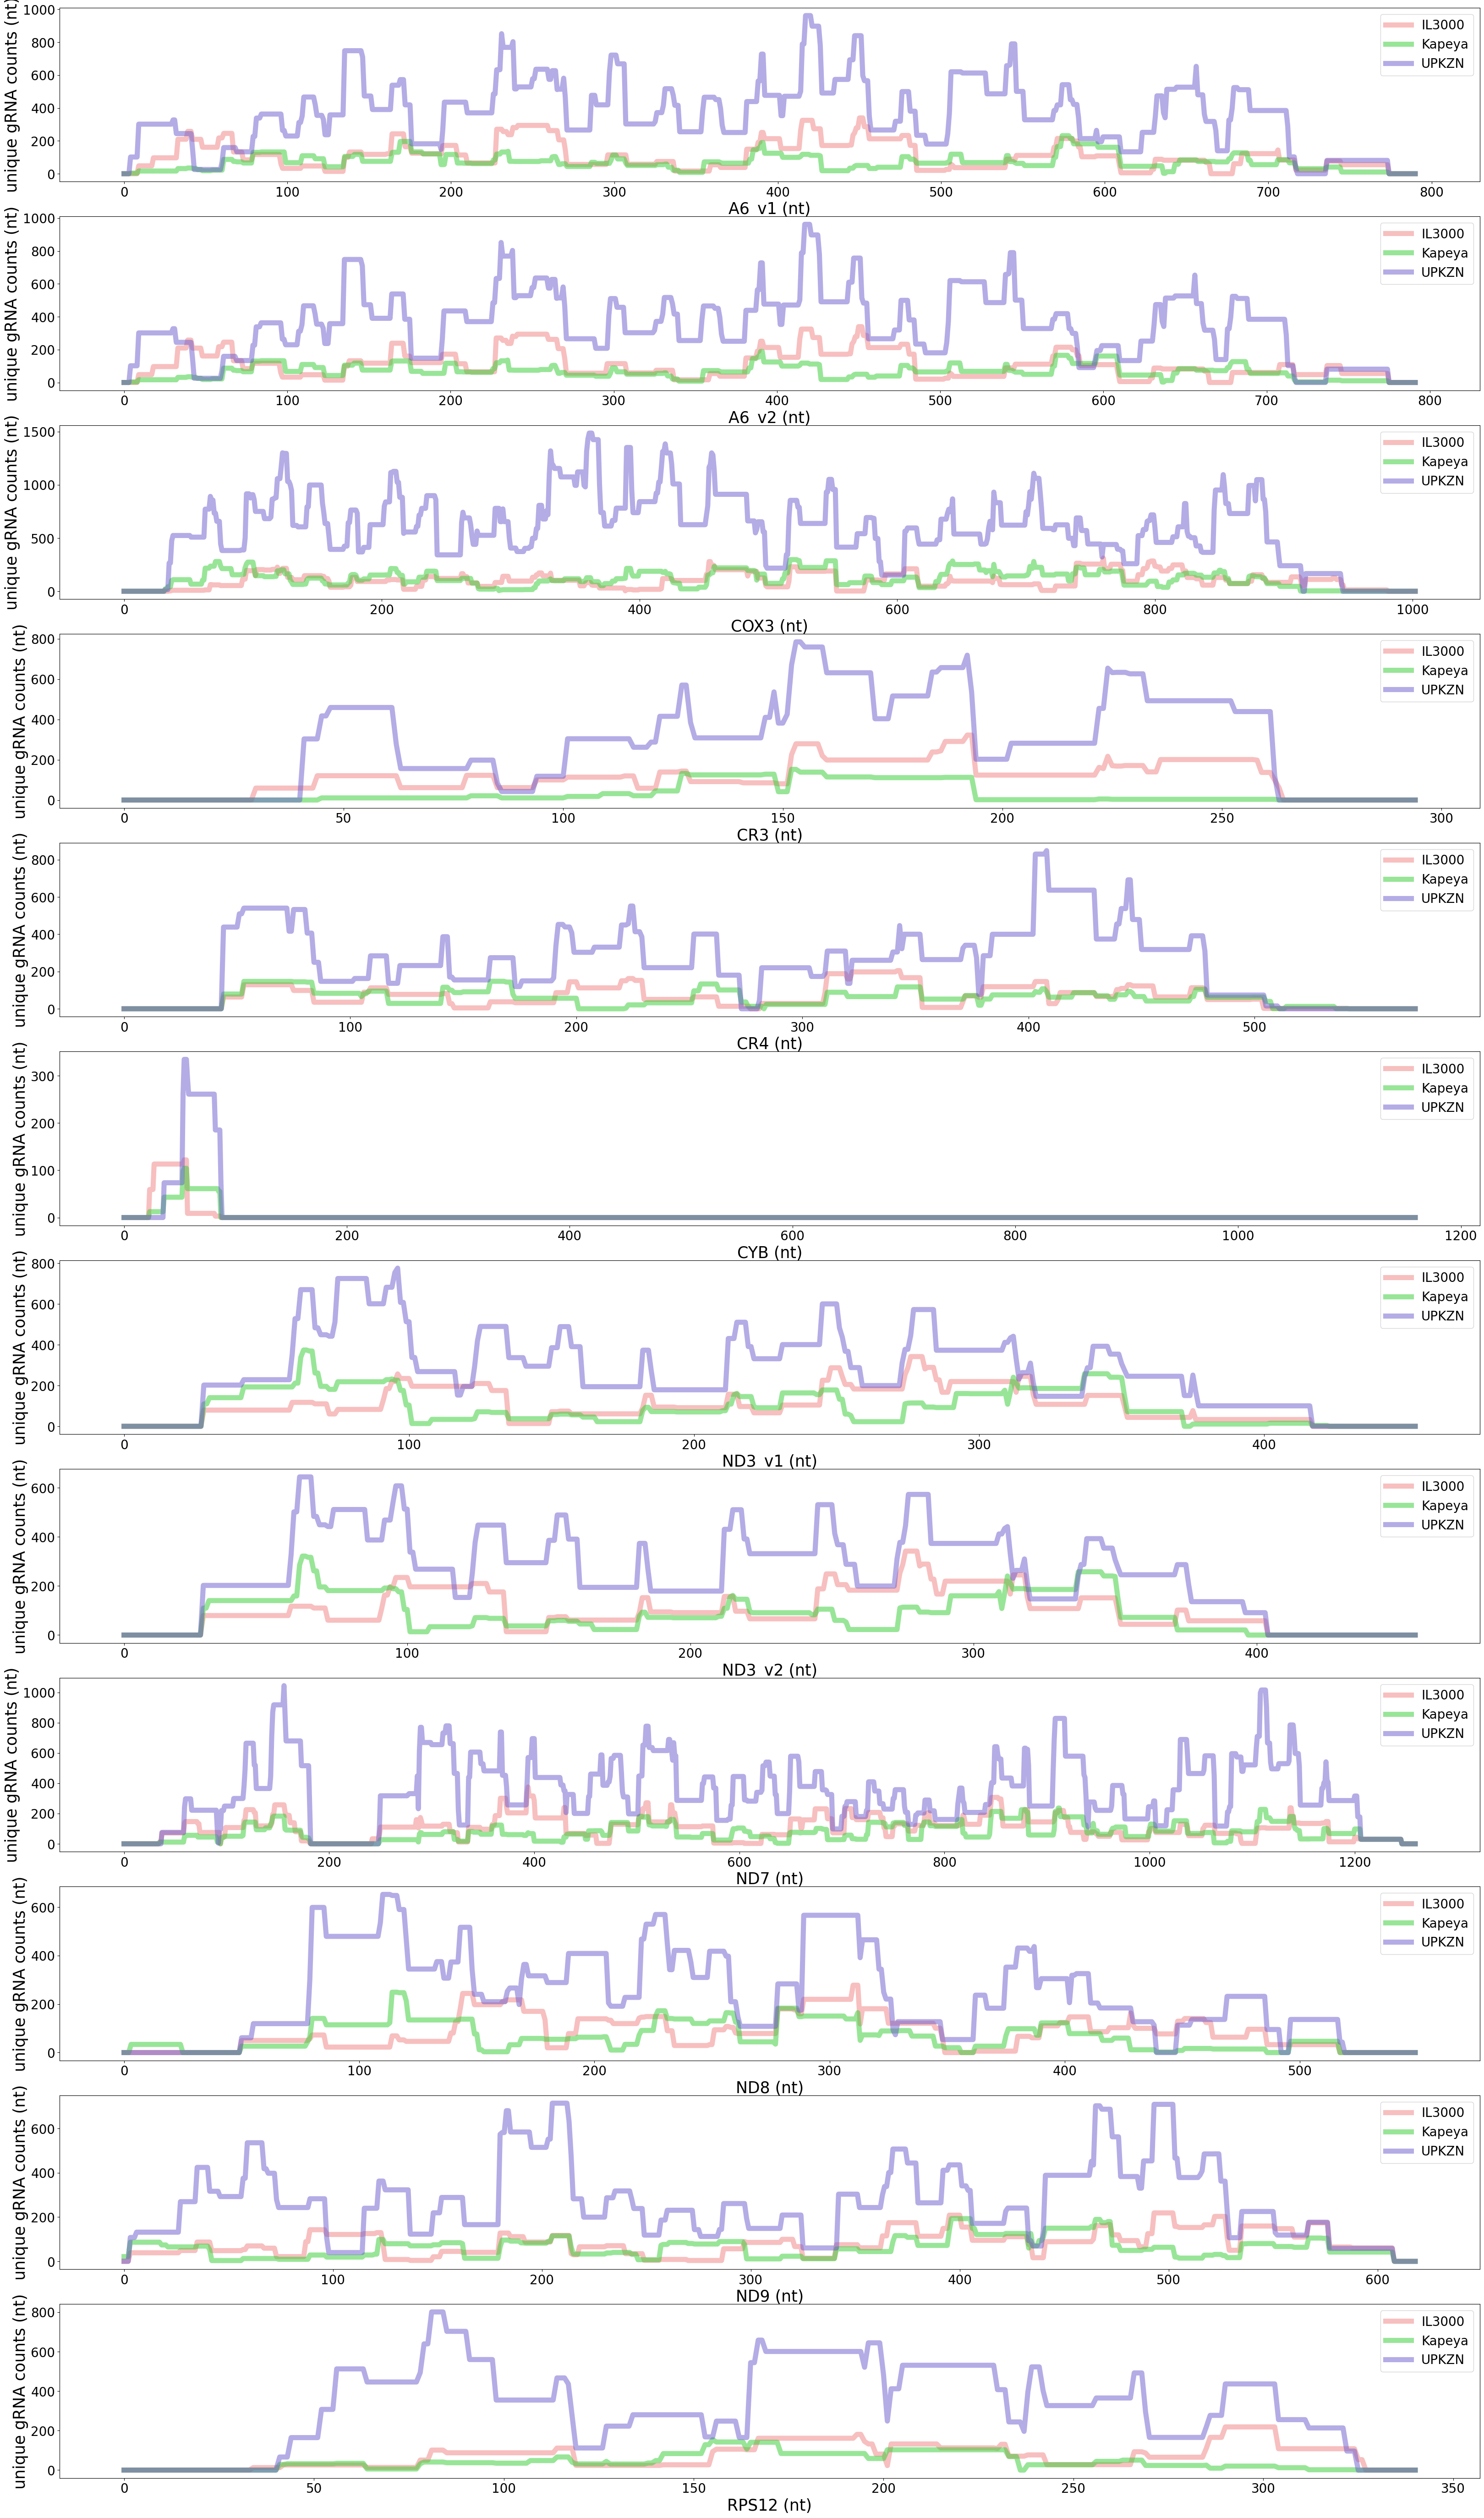

In [14]:
df_gRNA_copy=freq_editing_site_copy(strain_gRNA,small_u,anchor=6)
plot_coverage_depth_line_nucleotied_freq(df_gRNA_copy,insertions,small_u,w=30,figsize=(40, 70))

In [14]:
def pickle_out(out,outfile):
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(out, f)
    f.close()

In [15]:
strain_gRNA['IL3000']['IL3000_gRNA_0']

{'mO_name': 'IL3000_Maxicircle',
 'cassette_label': 'Maxi',
 'strand': 'template',
 'length': '52',
 'rel_start': '0',
 'circle_start': '0',
 'circle_end': '52',
 'mRNA_name': 'ND7',
 'product': 'ND7',
 'mRNA_start': '1200',
 'mRNA_end': '1252',
 'mRNA_seq': 'AuuGuGuAuGUUuuuGUUuAAAUAGGuuuuuuuuuuGACUGUCAAAAUAUAU',
 'gRNA_seq': 'UAAUGCAUAUAAAAACAGAUUUAUUUAAAGAAAAAACUGGUAGUUUUAUAUA',
 'pairing': '|||::||||:|||||||:||||||::|||:|||||||||::|||||||||||',
 'mismatches': '0',
 'anchor_len': '11',
 'name': 'Maxicircle_gND7(1201-1252)',
 'anchor_type': 'initiator',
 'rel_pos': '0',
 'family_no': '45',
 'family_end': '1252',
 'family_id': 'ND7-Maxit-1252',
 'copy': 30.0}

In [16]:
#combine gRNAs
grna_dict=strain_gRNA['IL3000']|strain_gRNA['Kapeya']|strain_gRNA['UPKZN']
#print(len(grna_dict),[len(strain_gRNA[s]) for s in strain_gRNA],sum([len(strain_gRNA[s]) for s in strain_gRNA]))
pickle_out(grna_dict,f'/home/jovyan/Tcongo_PacBio/Workfiles/Tc_gRNAs_{date}.pickle')
pickle_out(strain_gRNA,f'/home/jovyan/Tcongo_PacBio/Workfiles/Tc_straingRNAs_{date}.pickle')

mean: 42.692727272727275 sd: 5.49


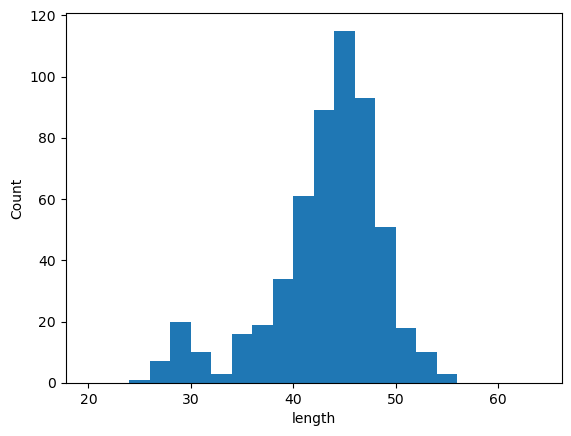

In [17]:
#
def plot_stats(key,grna_dict,s=20,e=65):
    x=[int(grna_dict[g][key]) for g in grna_dict]
    mean=sum(x)/len(x)
    sd=round(statistics.stdev(x),2)
    print(f"mean: {mean} sd: {sd}")
    fig,ax = plt.subplots(1,1)  #,figsize=(figw,figh)
    ax.hist(x,bins=range(s,e,2))
    ax.set_ylabel('Count')
    ax.set_xlabel(key)
    plt.show()
    
plot_stats('length',grna_il,s=20,e=65)

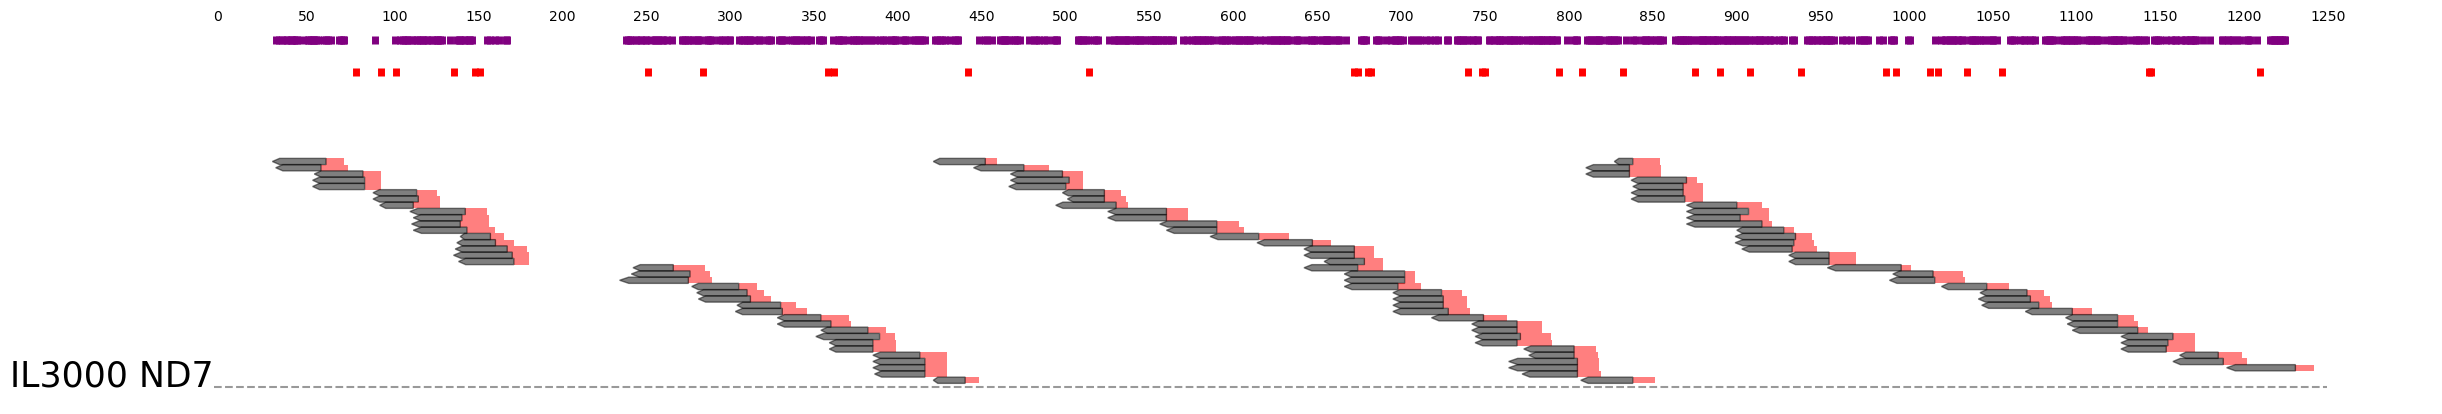

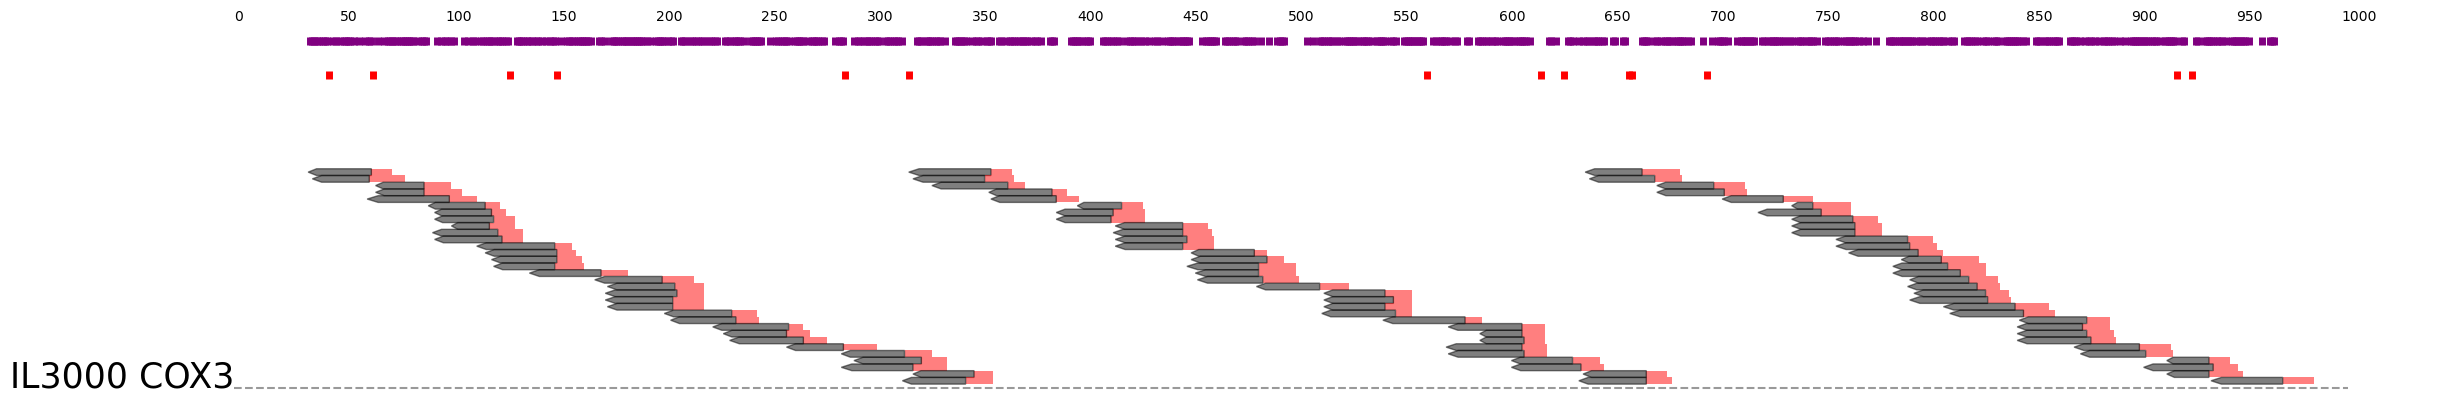

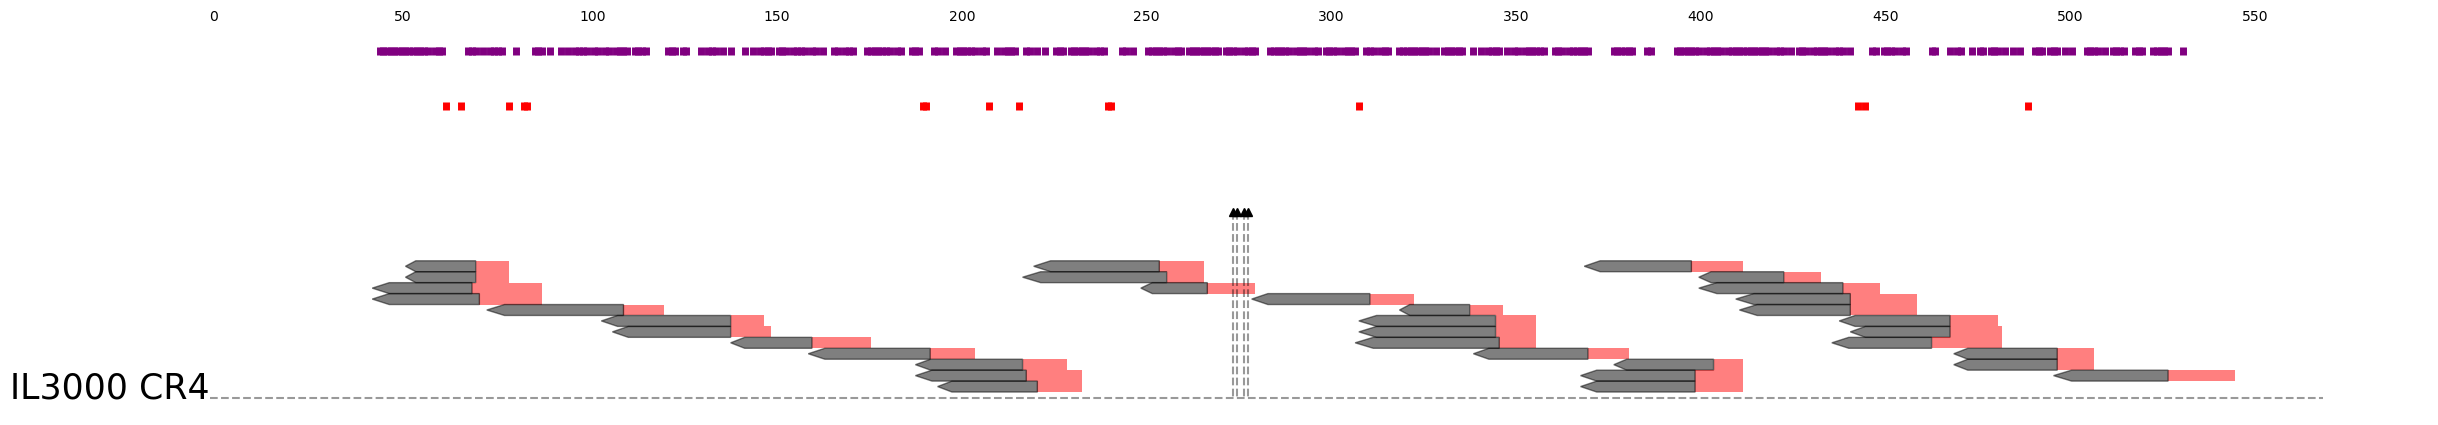

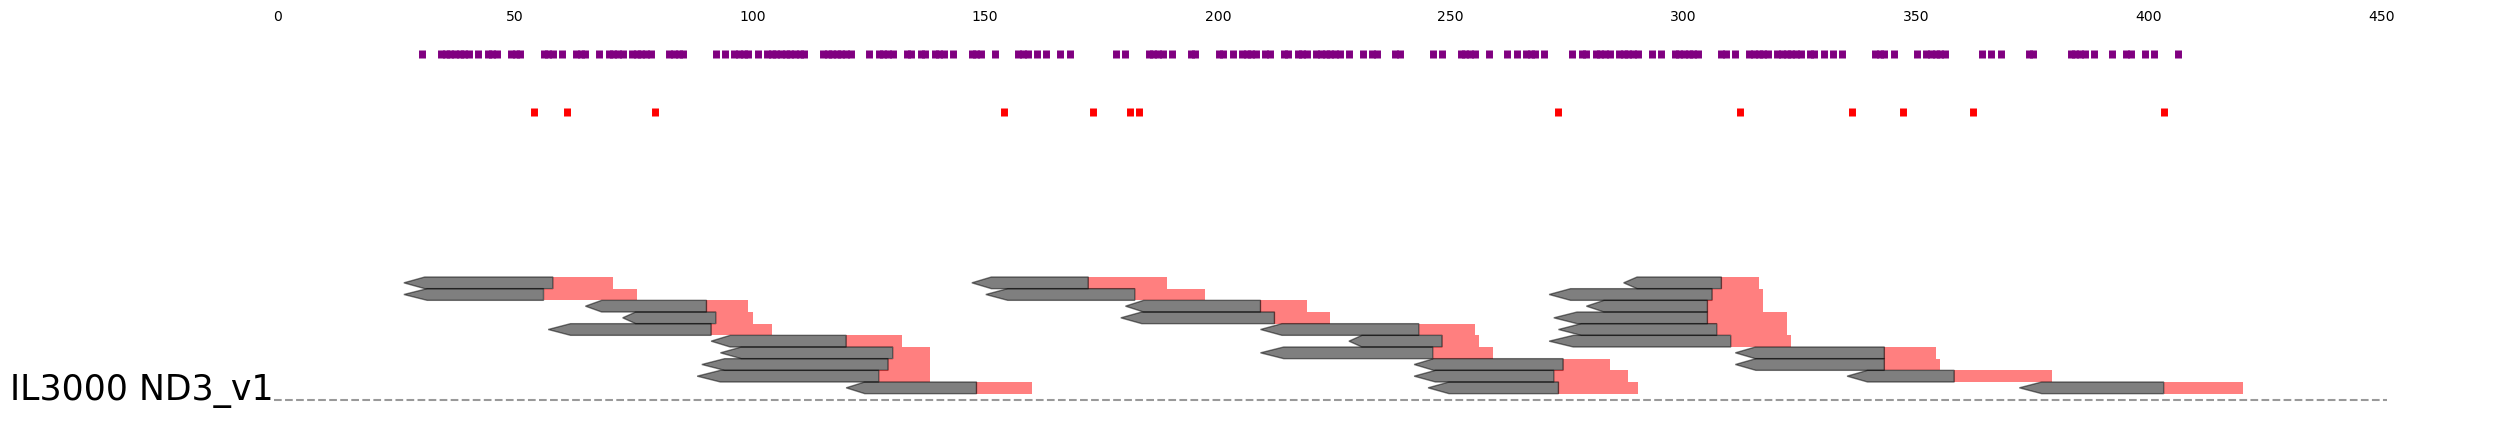

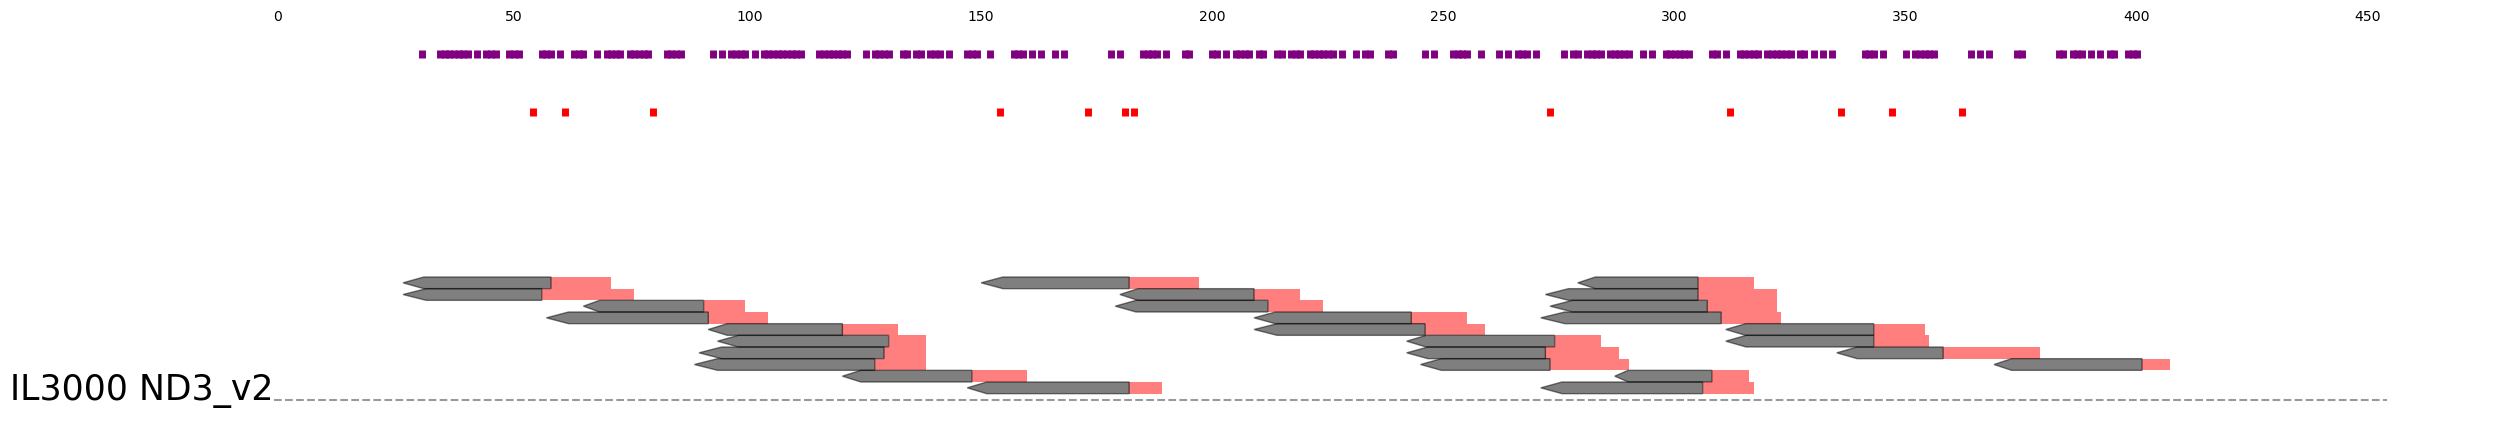

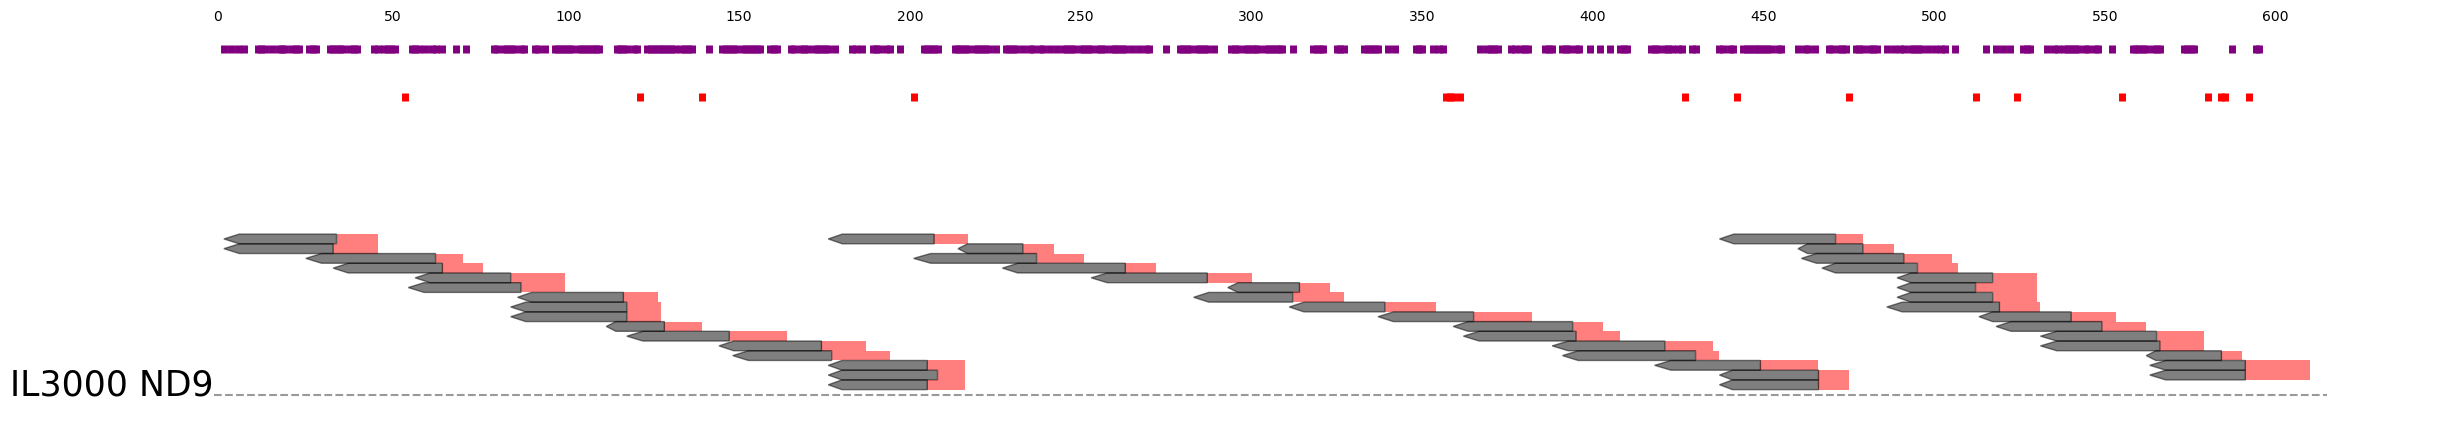

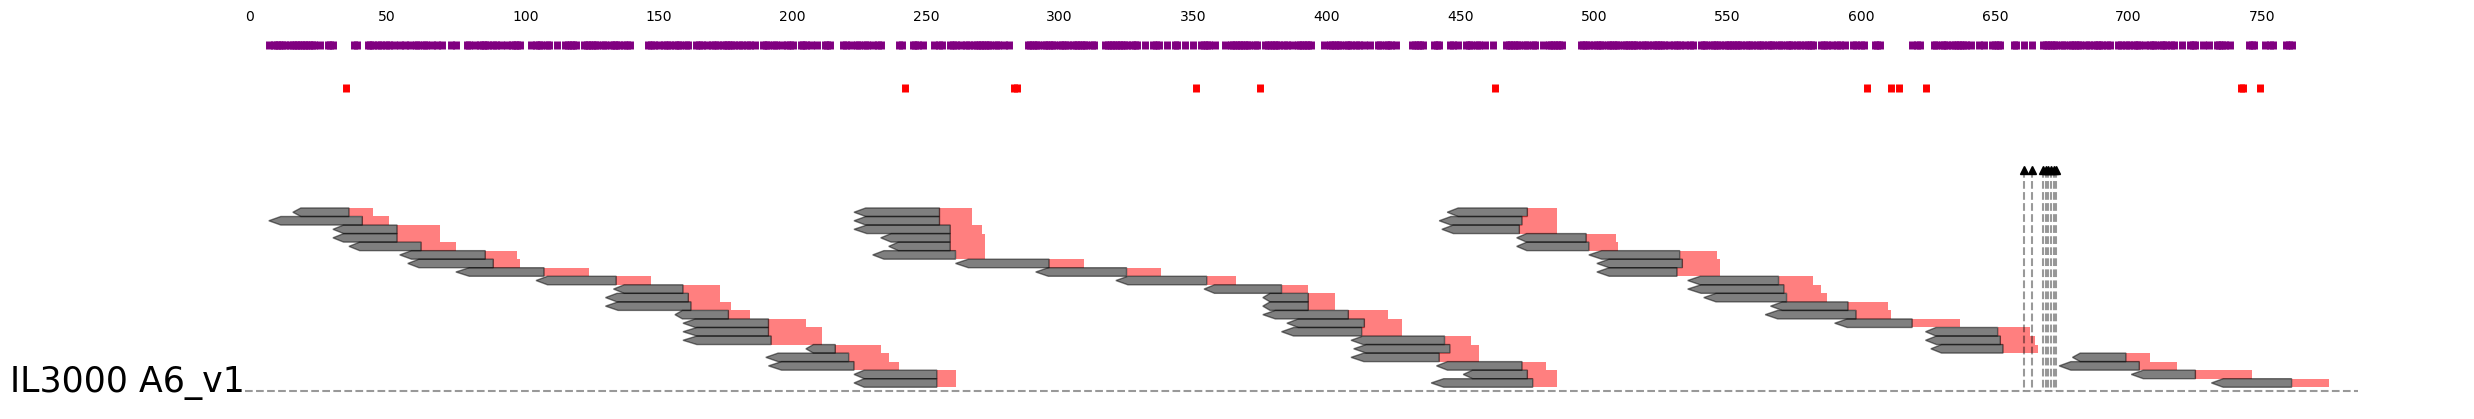

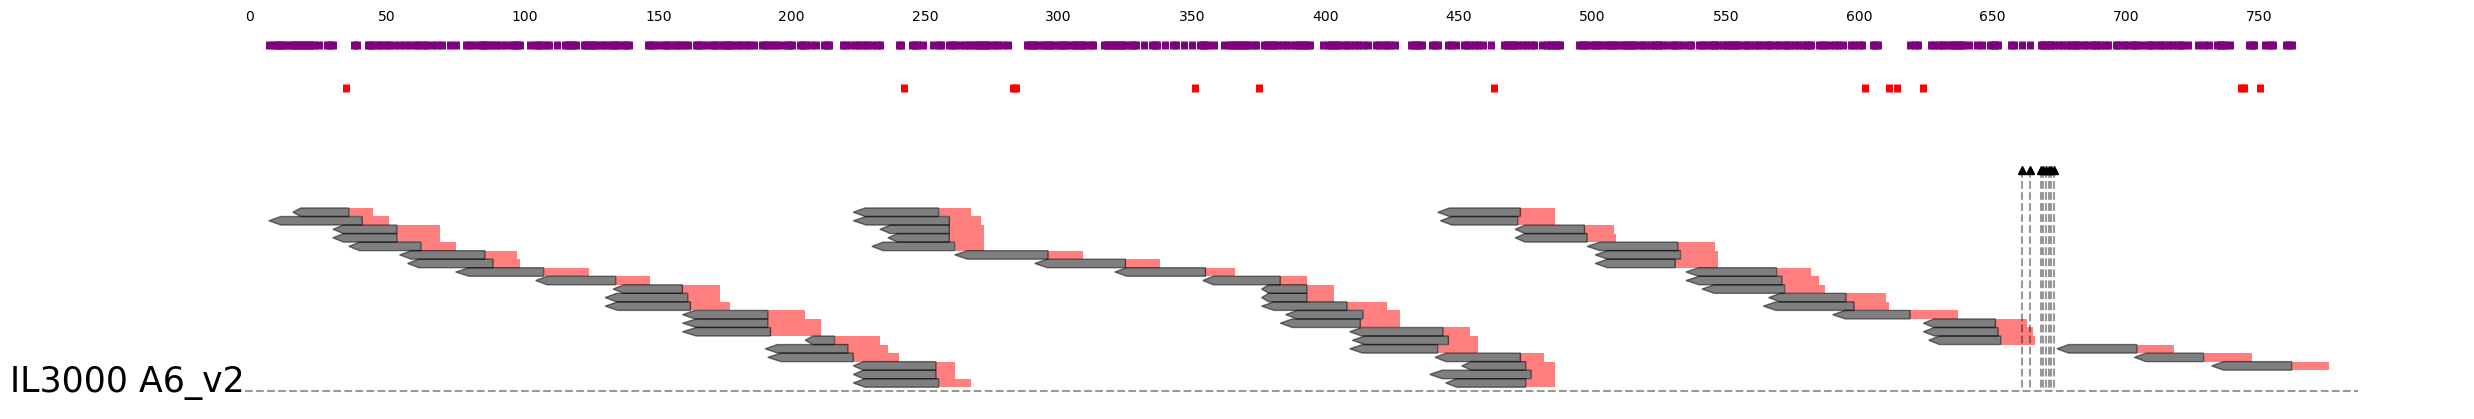

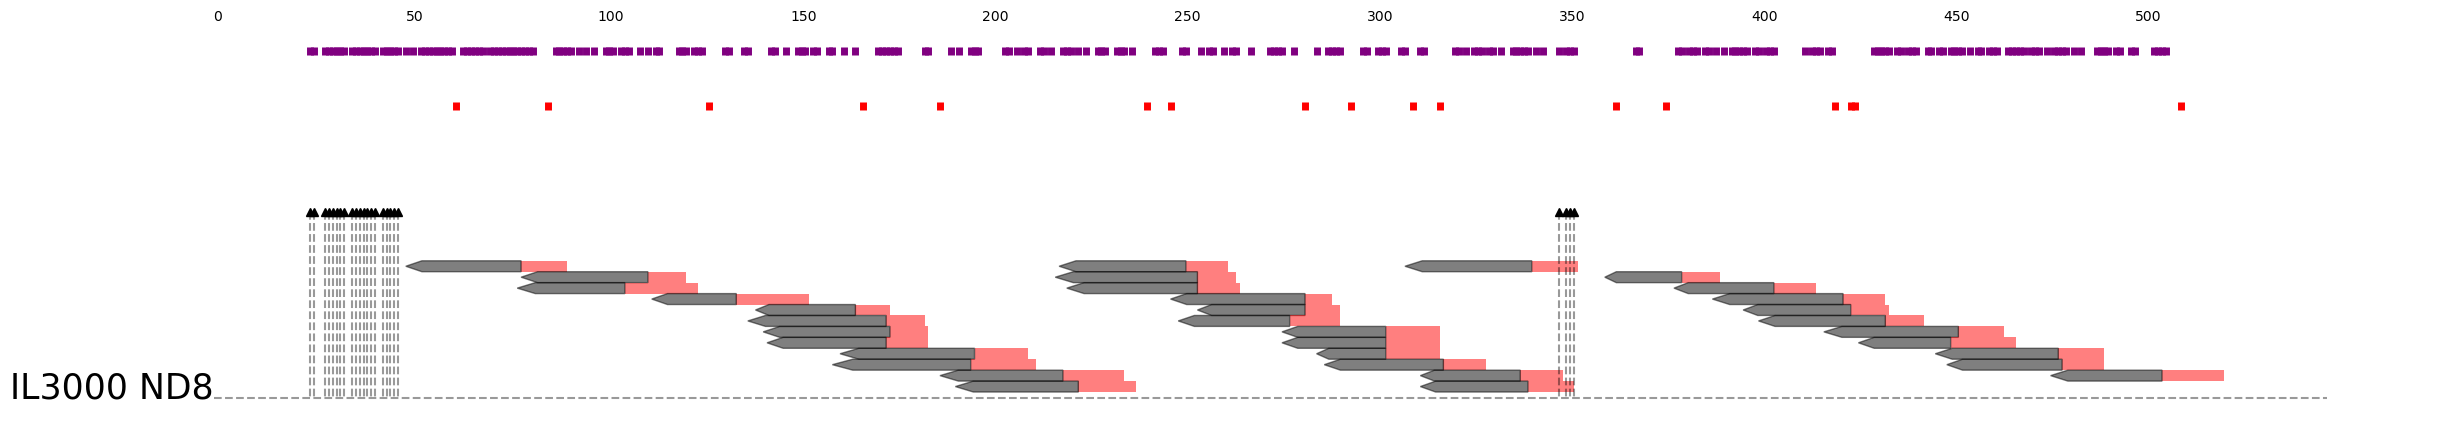

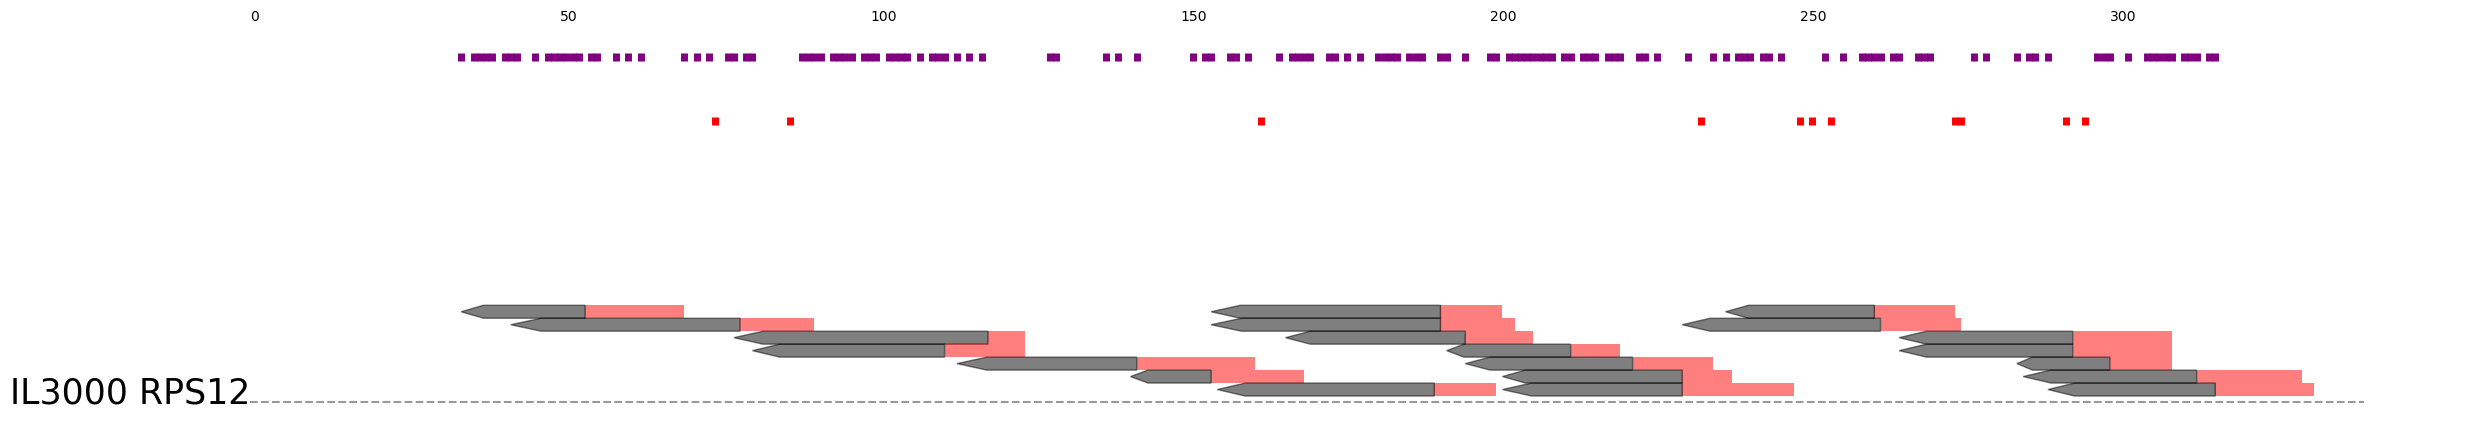

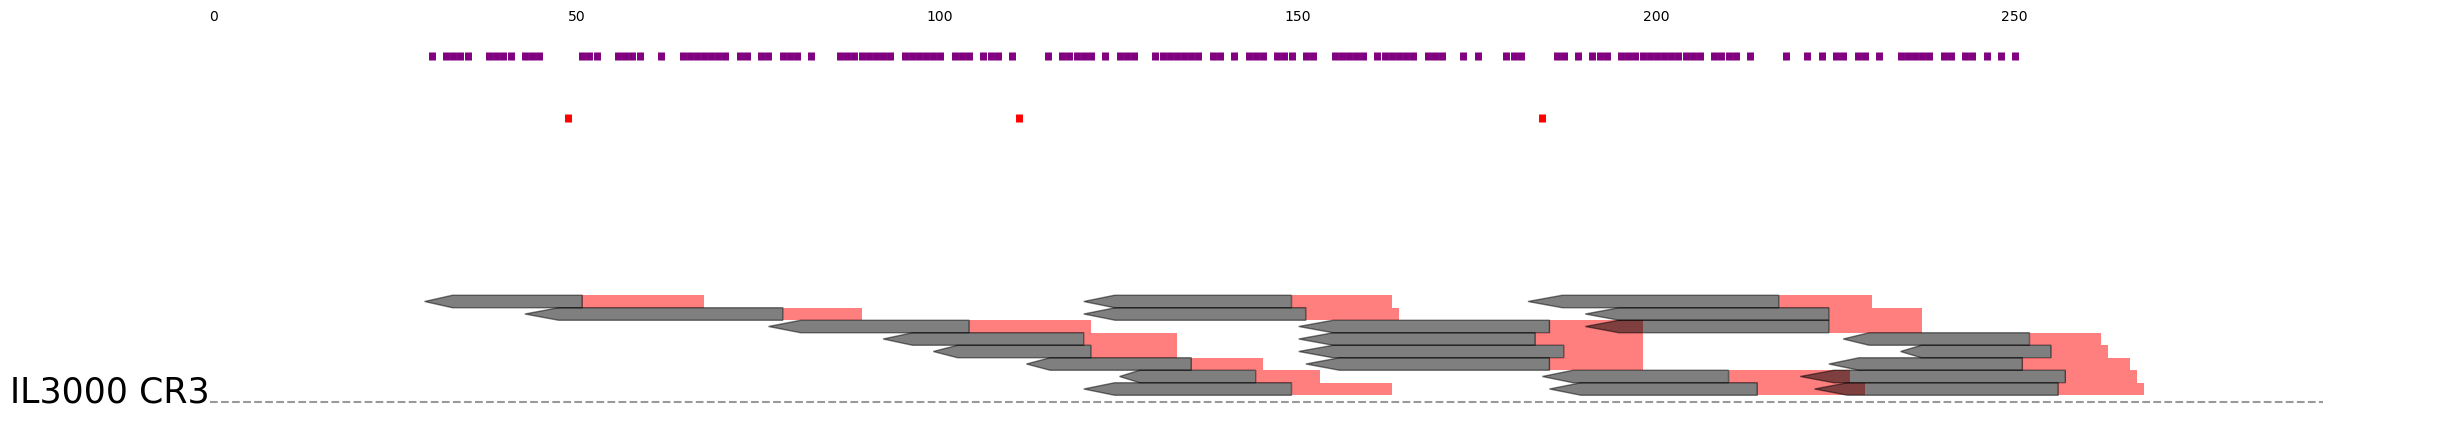

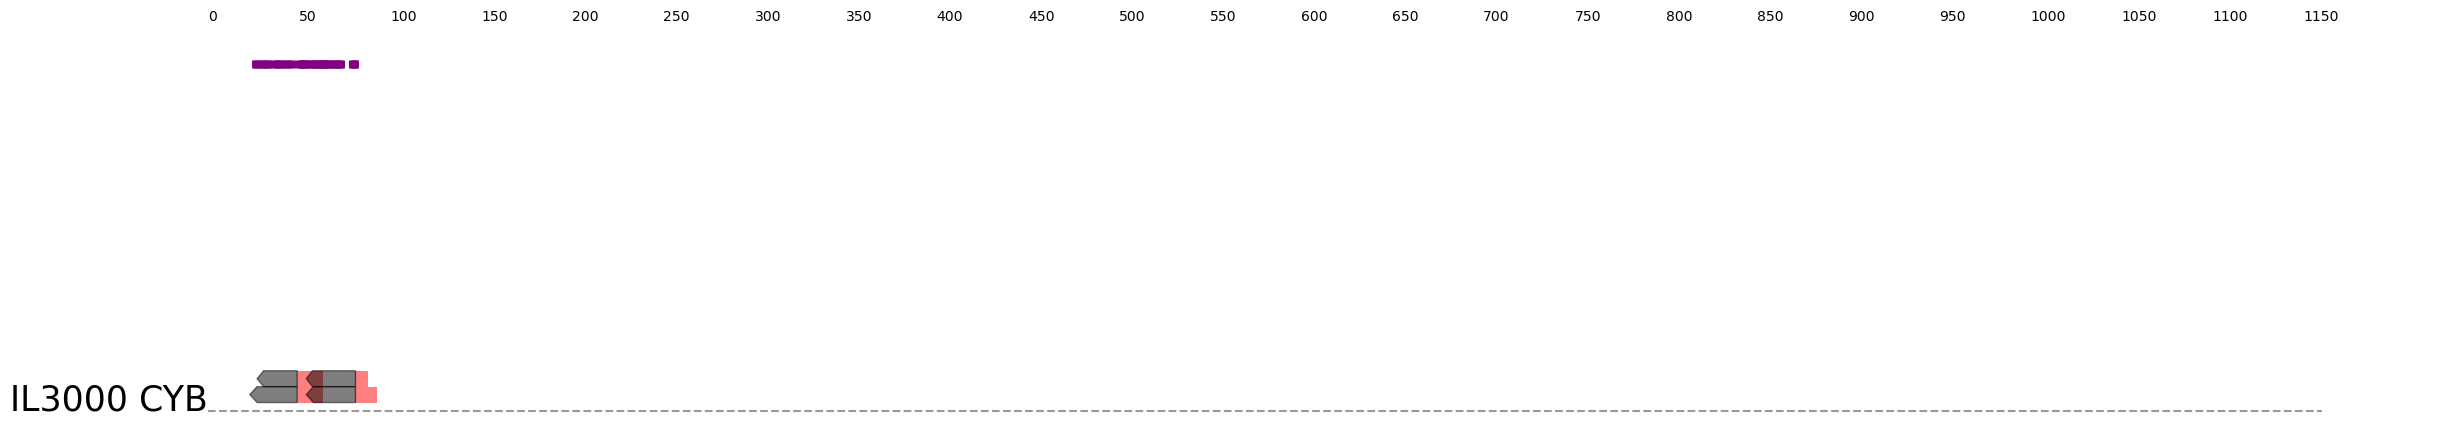

In [18]:
for mrna in mrna_il.keys():
    plot_mRNA_gRNA(mRNAs,{'IL3000':mrna_il},mrna,outdir,y=-3.3,fold=3,figw=30,figh=5,output=f'{mrna}_gRNA_coverage_1')